In [1]:
import scanpy as sc
import os
import anndata
import numpy as np
import pandas as pd
import seaborn as sns
import muon as mu
import warnings
from matplotlib.pyplot import rc_context
import decoupler as dc

from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix, issparse
from sklearn.neighbors import KNeighborsClassifier
from anndata import AnnData

import glob
from collections import defaultdict
from upsetplot import UpSet, from_indicators
import matplotlib.pyplot as plt
from collections import defaultdict
from upsetplot import from_indicators, UpSet
from sklearn.preprocessing import Binarizer
from adjustText import adjust_text
from scipy import stats
from scipy.stats import mannwhitneyu, kruskal

import gseapy as gp
from gseapy import barplot, dotplot
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

/home/sina.kanannejad/miniconda3/envs/pertpy-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
sc._settings.settings._vector_friendly=True
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=300,dpi_save = 300,
    facecolor="white",
    frameon=True, fontsize = 8
)
sc.settings.figdir = "/Figs/"
sns.set_theme(style="white")

In [4]:
color_dict_samples = {
    'AML3': 'darkred',
    'AML4': 'red',
    'AML5': 'tomato',
    'AML6': 'sienna',
    'AML7': 'darkorange',
    'AML8': '#8C564B',
    'AML9_Dx': 'gold',
    'AML9_Rel': 'seagreen',
    'AML10_Dx': 'khaki',
    'AML10_Rel': 'forestgreen',
    'AML11_Dx': 'darkviolet',
    'AML11_Rel': 'teal',
    'AML12_Dx': '#2CA02C',
    'AML12_Post': '#D62728',
    'AML12_Rel': '#9467BD',
    'AML13_Dx': '#8C564B',
    'AML13_Post': '#E377C2',
    'AML13_Rel': '#7F7F7F',
    'AML14_Dx': '#BCBD22',
    'AML14_Rel': '#17BECF',
    'AML15_Dx': '#FF33CC',
    'AML15_Rel': '#33CCFF',
    'CB1': 'grey',
    'CB2': 'grey',
    'HD1': 'grey',
    'HD2': 'grey',
    'PBM': 'grey'
    }

color_dict_cyto = {'NUP98r': 'brown',
    'GLIS2': 'green',
    'DEK_NUP214': 'blue',
    'MNX1': 'olive',
    'KMT2Ar': 'orange',
    'RUNX1_RUNX1T1': 'violet',
    'CBFB_MYH11': 'indigo',
    'Healthy': 'tan',
    'unknown': 'lightgrey'
    }

color_dict_state = {'Dx': 'teal',
    'relapse': 'maroon',
    'Healthy': 'tan',
    'post': 'navy'
    }

color_dict_sample_broad = {
    'AML3': 'green',
    'AML4': 'red',
    'AML5': 'crimson',
    'AML6': 'orange',
    'AML7': 'navy',
    'AML8': 'blue',
    'AML9': 'skyblue',
    'AML10': 'brown',
    'AML11': 'khaki',
    'AML12': 'coral',
    'AML13': 'magenta',
    'AML14': 'darkmagenta',
    'AML15': 'olive',
    'AML16': '#6A5ACD',    # SlateBlue
    'AML17': '#20B2AA',    # LightSeaGreen
    'AML19': '#FF6347',    # Tomato
    'Healthy': 'tan'
}

color_dict_LSC2 = {'High_LSC_score': 'brown',
    'Medium_LSC_score': 'rosybrown',
    'Low_LSC_score': 'green',
    'HSCs': 'blue',
    }

Malignant_normal = {'Malignant_LSC': 'brown',
    'Malignant_Blast': 'rosybrown',
    'Healthy_micro_env': 'green'
    } 

color_dict_immuno = {
    "Erythroid_like": "#E41A1C",  # Bright Red  
    "Primitive_like": "#FF7F00",  # Vivid Orange  
    "GMP_like": "#377EB8"  # Deep Blue  
}

color_malig = {
    "malignant": "darkred",   
    "normal": "lightblue",   
    "Post": "grey"  
}

colors_Kclust = {
    0: '#FF7F00',  # Orange
    1: '#377EB8',  # Blue
    2: '#4DAF4A',  # Green
    3: '#E41A1C',  # Red
    4: '#984EA3',  # Purple
    5: '#FFD700',  # Gold
    6: '#A65628'   # Brown
}

CELLTYPE_COLORS = {
    'Erythroid_Prog': '#E41A1C',  # red
    'Progenitors': '#377EB8',     # blue
    'HSC': '#984EA3',            # changed to purple
    'Erythroid': '#66C2A5',      # changed to mint
    'GMP': '#FF7F00',           # orange
    'B_prog': '#FFFF33',        # yellow
    'B Cell': '#A65628',        # brown
    'T Cells': '#F781BF',       # pink
    'Monocytes': '#E6AB02',     # changed to gold
    'NK Cells': '#A6D854',      # changed to lime
    'ProMono': '#FC8D62',       # coral
    'DCs': '#8DA0CB'            # light blue
}

In [5]:
def plot_stacked_barplot(adata, groupby_columns, color_dict, figsize=(10, 10), save_path = None):
    """
    Plots a stacked barplot with the x-axis as the first group and color based on the second group.
    The y-axis is normalized to 100%.
    
    Parameters:
    adata : AnnData object
        Annotated data matrix.
    groupby_columns : list
        List containing two strings specifying the `obs` columns to group by (e.g., ["cluster", "sample_major"]).
    color_dict : dict
        Dictionary mapping categories in the second group to colors.
    figsize : tuple
        Figure size.
    """
    group, count = groupby_columns
    
    # Create a DataFrame with group counts
    df = adata.obs.groupby(groupby_columns).size().reset_index(name='count')
    
    # Normalize within each cluster
    df['percent'] = df.groupby(group)['count'].apply(lambda x: 100 * x / x.sum()).reset_index(drop=True)
    
    # Pivot for plotting
    pivot_df = df.pivot(index=group, columns=count, values='percent').fillna(0)
    
    # Ensure correct color mapping
    colors = [color_dict.get(c, "gray") for c in pivot_df.columns]
    
    # Plot
    pivot_df.plot(kind='bar', stacked=True, figsize=figsize, color=colors, width=0.7)
    plt.ylabel("Percentage")
    plt.xlabel(group)
    plt.legend(title=count, bbox_to_anchor=(1, 1))
    plt.title("Stacked Bar Plot of {} by {}".format(group, count))
    plt.savefig(save_path,
                   dpi=300,  # High resolution
                   bbox_inches='tight',  # Tight bounding box
                   pad_inches=0.2,  # Add some padding
                   format='pdf')  # You can also use 'pdf', 'svg', or 'jpg
    plt.show()

In [12]:
AML_all = mu.read("/pAML_main.h5mu")
combined_metadata = pd.read_csv("/meta_annotation.csv", index_col = 0)
malig_meta = pd.read_csv("/all_samples_malignancy_scores.csv", index_col = 0)
AML_all["rna"].obs["mapped_healthy"] = combined_metadata["annotation"]

AML_all["rna"].obs["malignancy_score"] = malig_meta["malignancy_score"]
AML_all["rna"].obs["malignancy_status"] = malig_meta["malignancy_status"]
AML_all["rna"].obs["mapped_healthy"] = combined_metadata["annotation"]

AML_malig = AML_all[(AML_all["rna"].obs["malignancy_status"].isin(["malignant"])) & 
                  (~AML_all["rna"].obs["mapped_healthy"].isin(["NK Cells", "B Cell", "T Cells"]))].copy()

AML_malig

MuData object with n_obs × n_vars = 158854 × 36682
  2 modalities
    rna:	158854 x 36601
      obs:	'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'sample', 'type', 'outlier', 'annotation', 'Cytogenetics', 'state', 'state_major', 'sample_major', 'immu_phe', 'EPPERT_CE_HSC_LSC', 'EPPERT_LSC_R', 'EPPERT_HSC_R', 'GAL_LEUKEMIC_STEM_CELL_UP', 'GENTLES_LEUKEMIC_STEM_CELL_UP', 'LSC104_Ng2016_UP', 'LSPC_Quiescent', 'LSPC_Primed_Top100', 'Bulk_LSC_score', 'LSC104_Ng2016_DOWN', 'MLL_LSC_Somervaille2009_UP', 'MLL_LSC_Somervaille2009_DOWN', 'LSPC_Cycle_Top100', 'GMP_like_Top100', 'ProMono_like_Top100', 'Mono_like_Top100', 'cDC_like_Top100', 'GENTLES_LEUKEMIC_STEM_CELL_DN', 'GAL_LEUKEMIC_STEM_CELL_DN', 'S_score', 'G2M_score', 'Blast_score', 'Blast_extended', 'mapped_healthy', 'malignancy_score', 'malignancy_status', 'cluster'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'Cytogenetics_colors', 'annotation_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'sample_major_colors', 'state_colors', 'umap'
      obsm:	'X_pca', 'X_umap', 'aucell_estimate', 'uninteg_UMAP'
      varm:	'PCs'
      layers:	'lognorm_counts', 'raw_counts'
      obsp:	'connectivities', 'distances'
    adt:	158854 x 81
      obs:	'sample', 'type', 'annotation'
      layers:	'raw_counts'

In [7]:
os.chdir("/all_LSC_Blast_scores_k6")
csv_files = glob.glob("*_selected_genes*.csv")
len(csv_files)

19

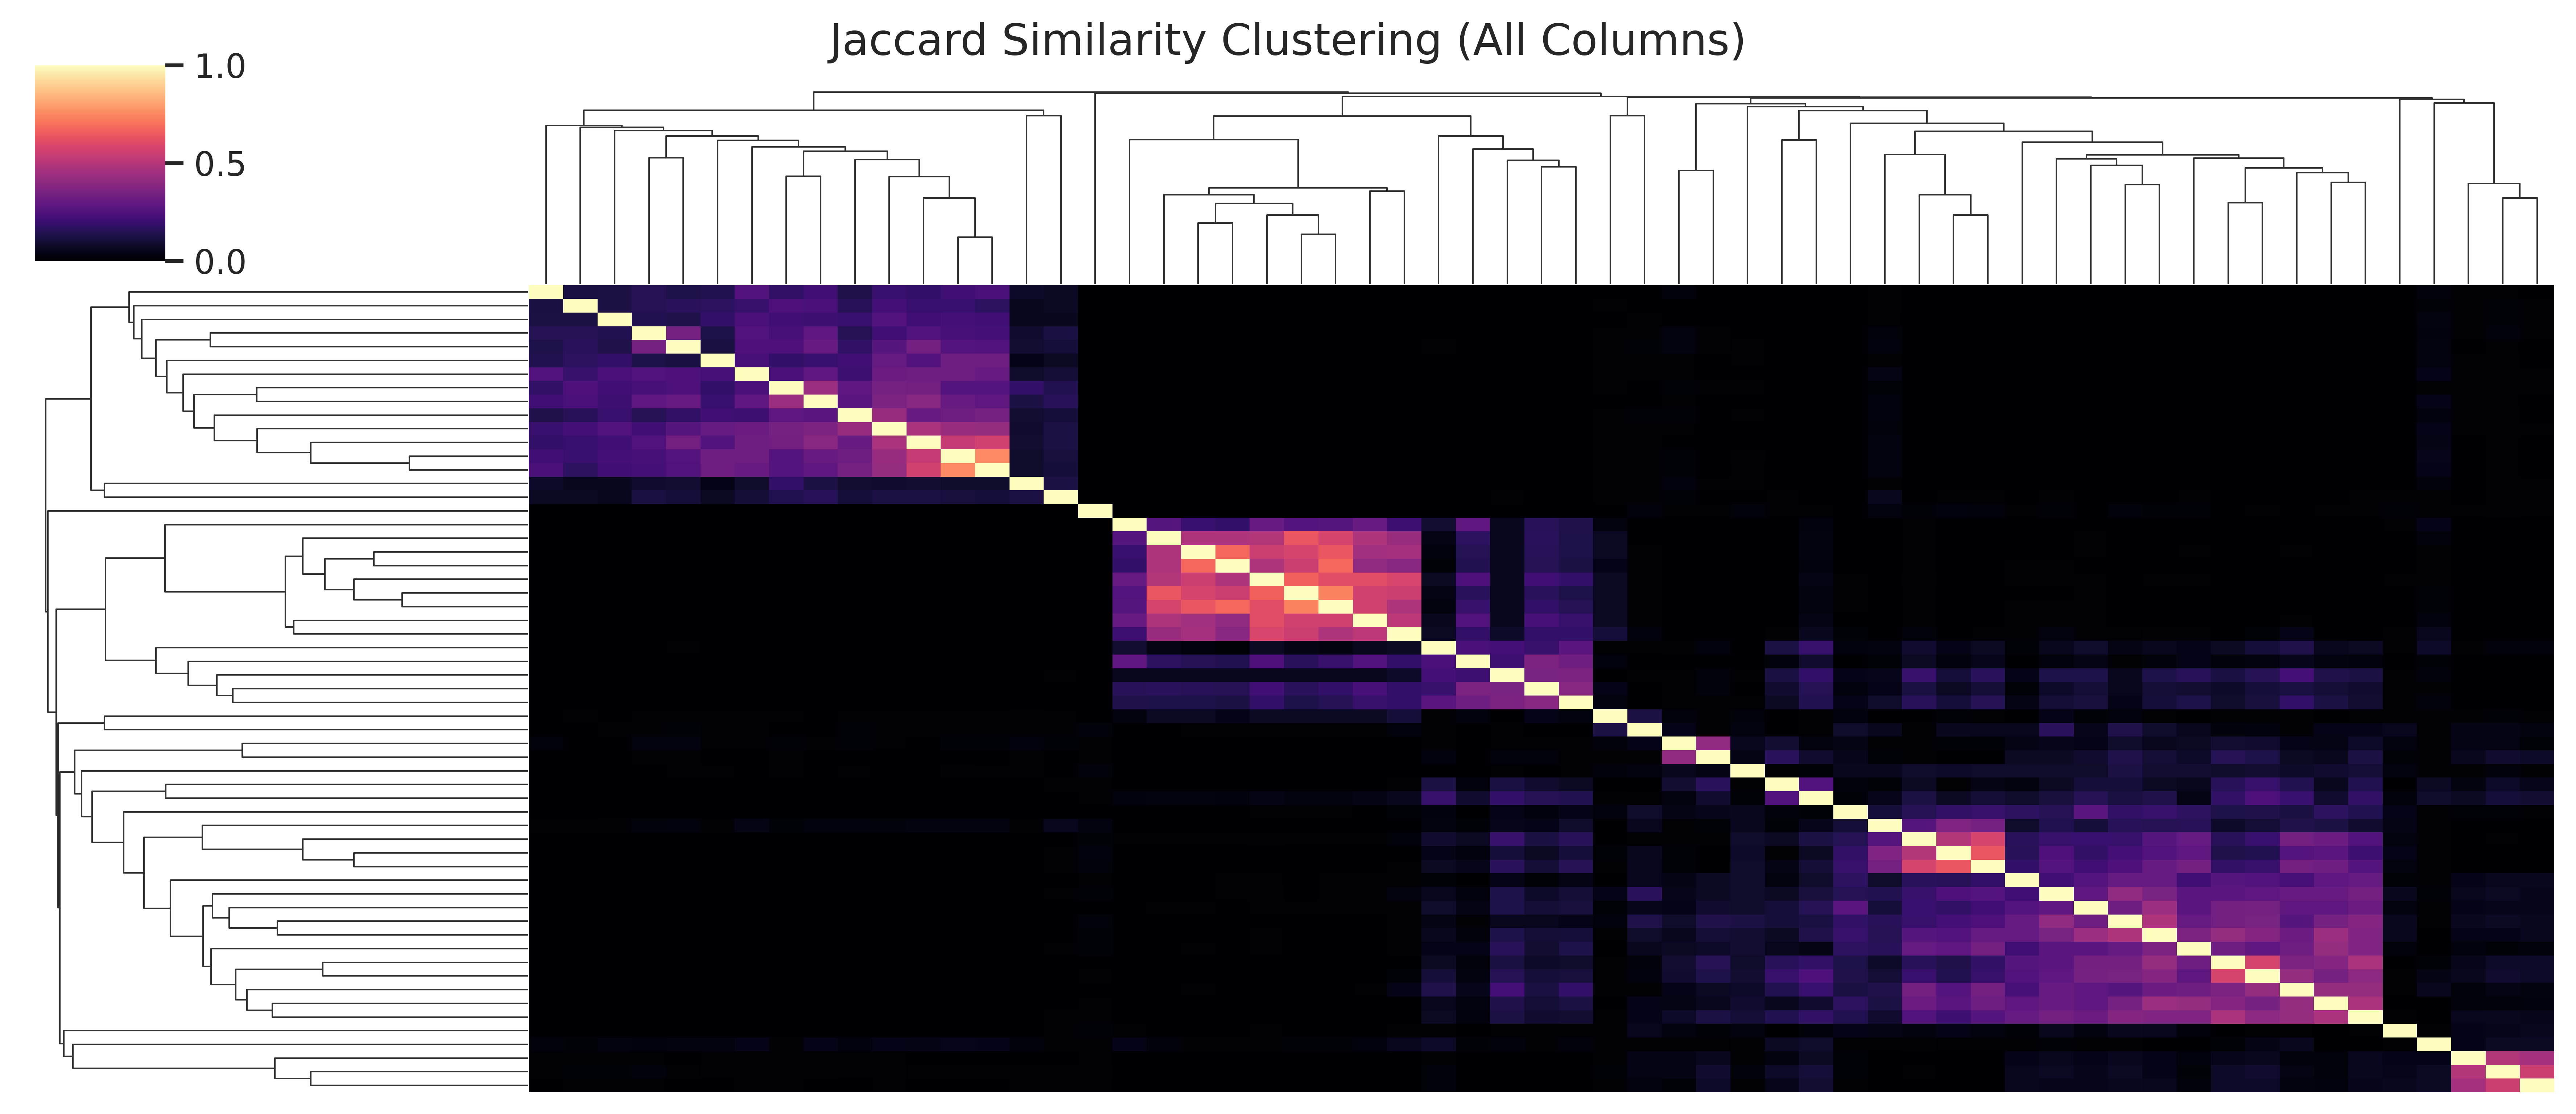

In [8]:

# Set working directory
os.chdir("/all_LSC_Blast_scores_k6")
csv_files = glob.glob("*_selected_genes*.csv")

# Collect usage sets from all columns
usage_sets = {}

for file in csv_files:
    df = pd.read_csv(file)
    base = os.path.splitext(os.path.basename(file))[0]
    
    for col in df.columns:
        # Skip columns with all NaNs or non-relevant columns if needed
        if df[col].dropna().empty:
            continue
        
        usage_sets[f"{base}_{col}"] = set(df[col].dropna().astype(str))

# Create label list
labels = list(usage_sets.keys())

# Build similarity matrix
jac_sim_matrix = pd.DataFrame(index=labels, columns=labels, dtype=float)

for k1 in labels:
    for k2 in labels:
        s1, s2 = usage_sets[k1], usage_sets[k2]
        union = s1 | s2
        intersection = s1 & s2
        jaccard = len(intersection) / len(union) if union else 0
        jac_sim_matrix.loc[k1, k2] = jaccard

# Convert similarity to distance
distance_matrix = 1 - jac_sim_matrix.astype(float)

# Condense distance matrix and perform clustering
condensed_dist = squareform(distance_matrix)
linkage_matrix = linkage(condensed_dist, method='average')

# Plot clustermap
sns.clustermap(
    jac_sim_matrix,
    row_linkage=linkage_matrix,
    col_linkage=linkage_matrix,
    cmap="magma",
    figsize=(12, 5),
    xticklabels=False,
    yticklabels=False
)

plt.suptitle("Jaccard Similarity Clustering (All Columns)", y=1.02)

plt.savefig('/jaccard_similarity_clustermap.png', 
            dpi=300,  # High resolution
            bbox_inches='tight',  # Tight bounding box
            pad_inches=0.2,  # Add some padding
            format='png')  # You can also use 'pdf', 'svg', or 'jpg'

plt.show()

In [14]:
# Extract labels
labels = jac_sim_matrix.index

# Split into LSC and Blast sets
lsc_labels = [l for l in labels if "LSC" in l]
blast_labels = [l for l in labels if "Blast" in l]

# Subset the matrix for LSC vs LSC
jac_lsc_lsc = jac_sim_matrix.loc[lsc_labels, lsc_labels].astype(float)
# Subset the matrix for Blast vs Blast
jac_blast_blast = jac_sim_matrix.loc[blast_labels, blast_labels].astype(float)

#mask diagonal

def mean_off_diagonal(mat):
    mat = mat.values
    # mask diagonal
    mask = ~np.eye(mat.shape[0], dtype=bool)
    return mat[mask].mean()

mean_lsc = mean_off_diagonal(jac_lsc_lsc)
mean_blast = mean_off_diagonal(jac_blast_blast)

print("Mean Jaccard similarity within LSCs:", mean_lsc)
print("Mean Jaccard similarity within Blasts:", mean_blast)


Mean Jaccard similarity within LSCs: 0.15672524512045888
Mean Jaccard similarity within Blasts: 0.09687243522648027



Mean Similarity Scores:
LSC vs LSC: 0.157
LSC vs Blast: 0.010
Blast vs Blast: 0.097


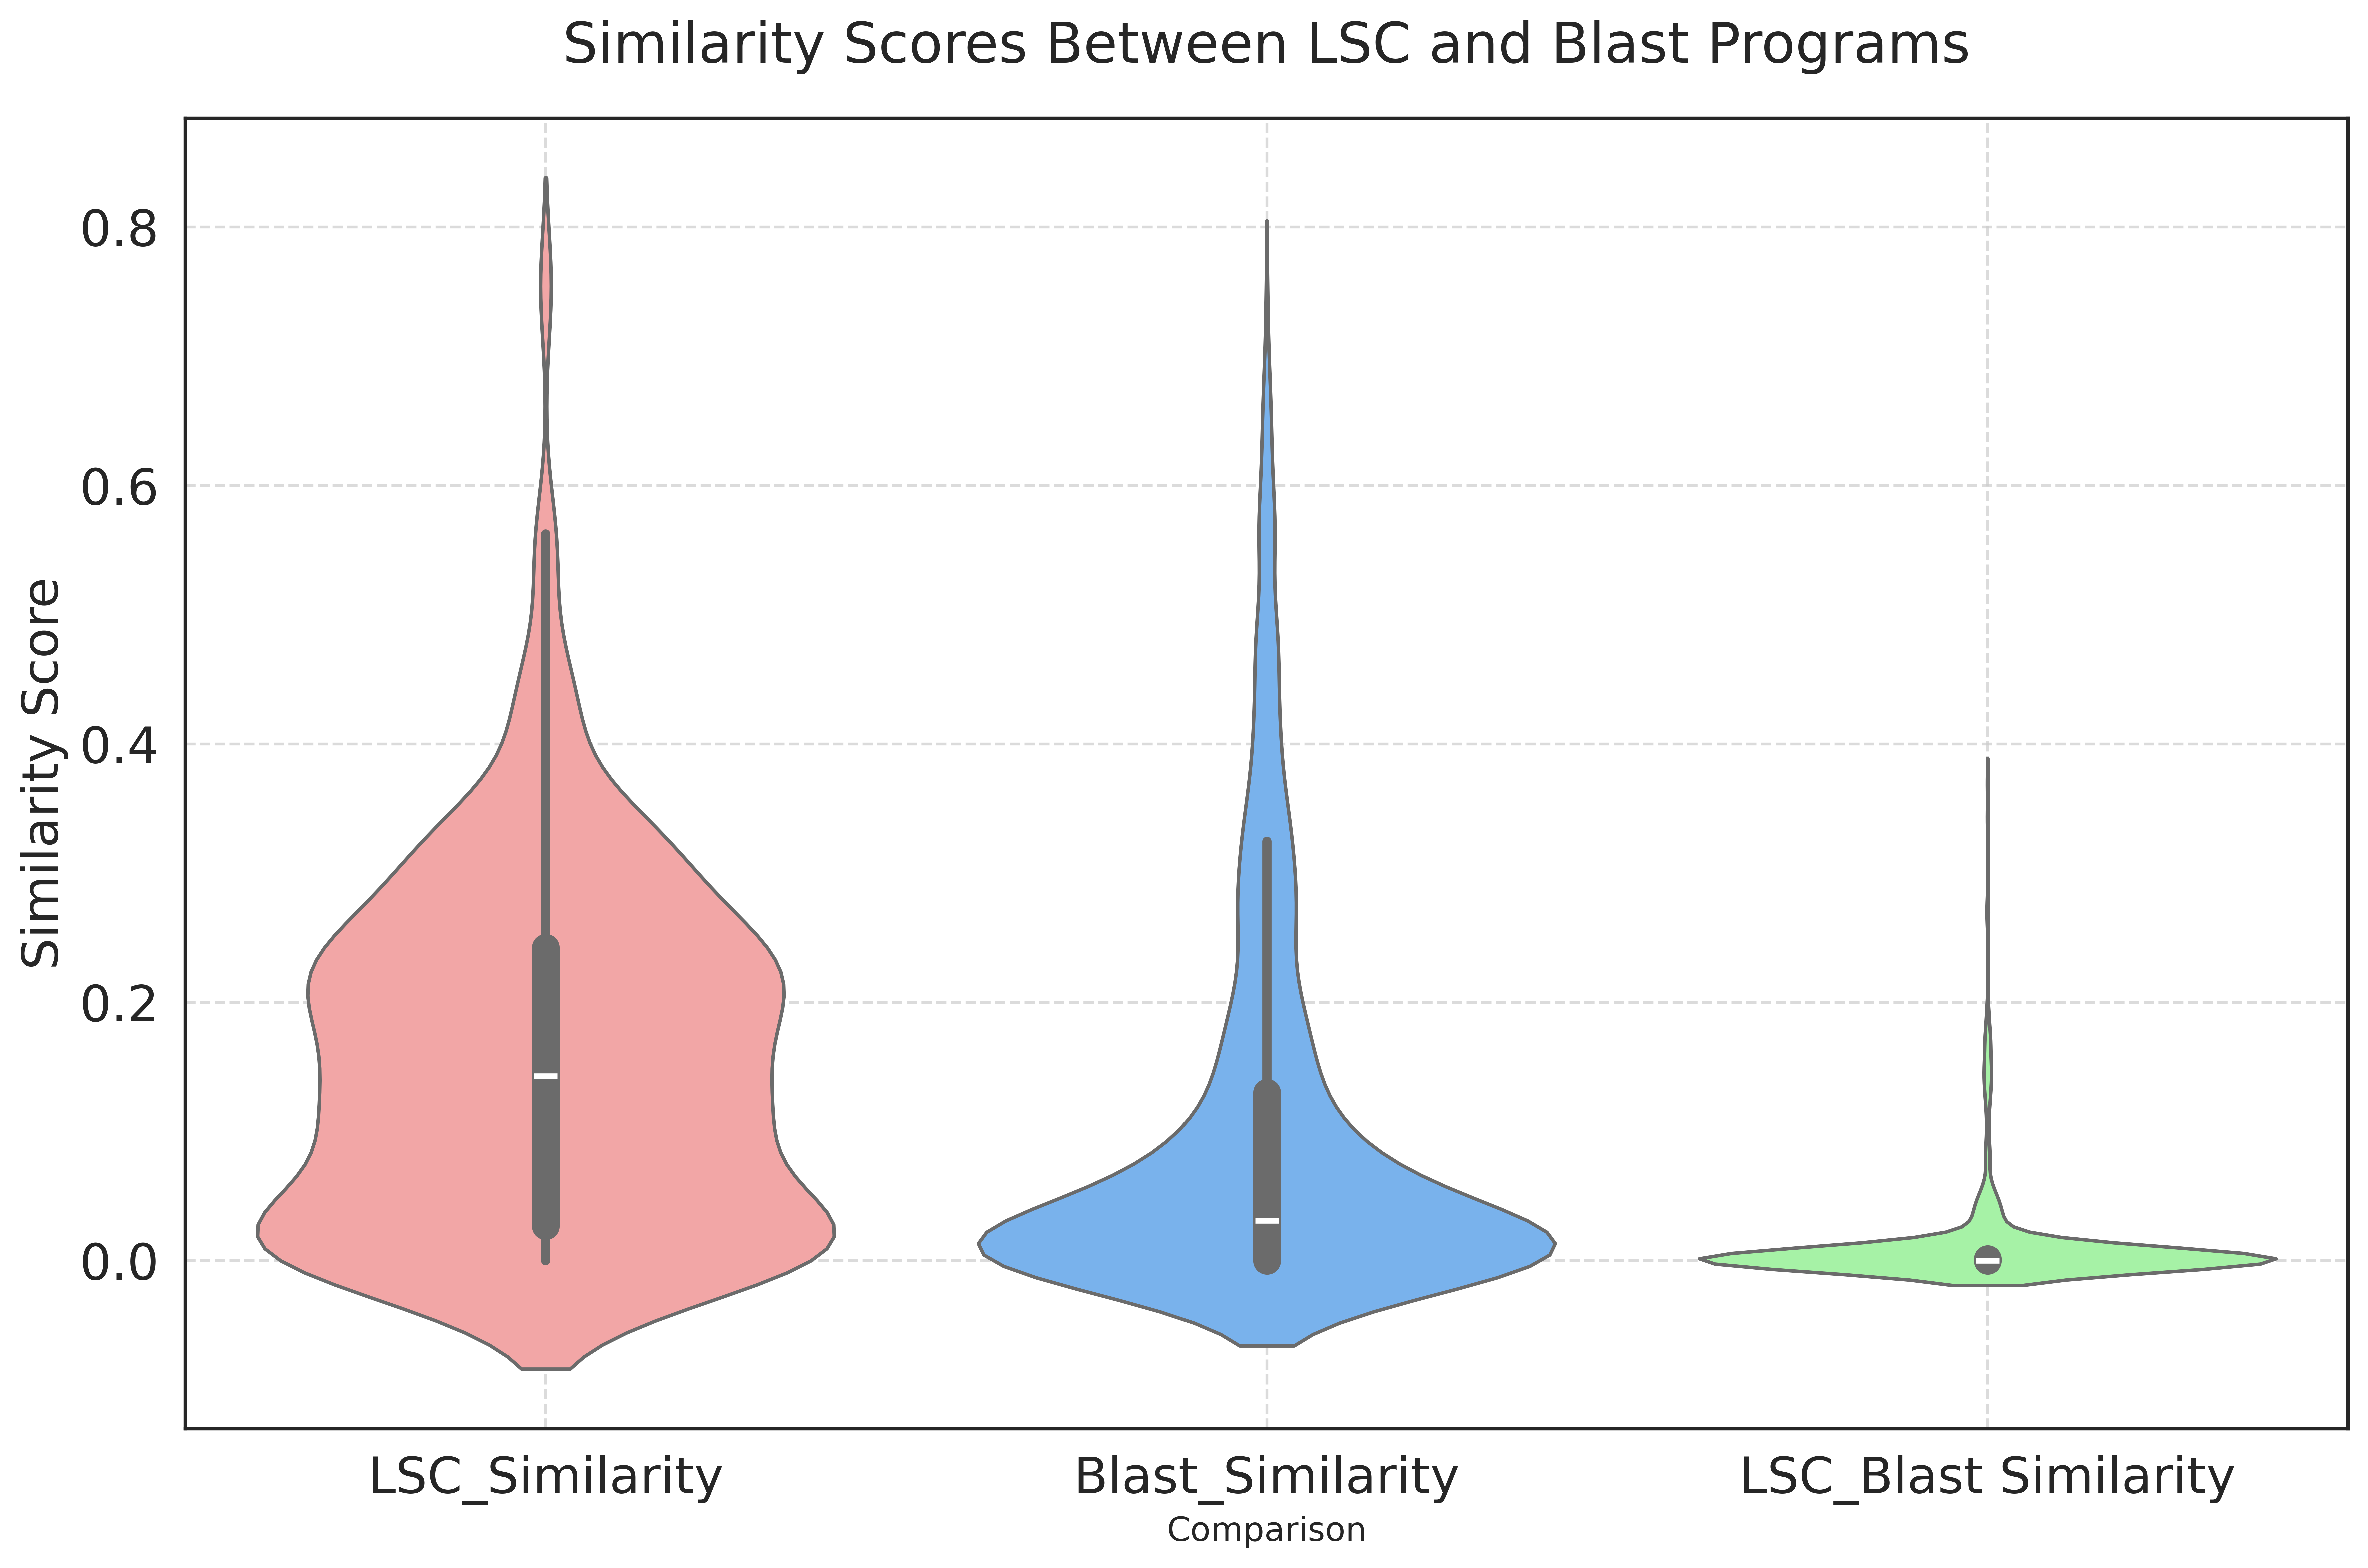

In [35]:
# Create boxplot for LSC vs Blast similarities
# First, identify LSC and Blast programs
lsc_programs = [col for col in jac_sim_matrix.columns if 'LSC' in col]
blast_programs = [col for col in jac_sim_matrix.columns if 'Blast' in col]

# Calculate mean similarities
lsc_lsc_similarities = []
lsc_blast_similarities = []
blast_blast_similarities = []

# LSC vs LSC similarities
for i in lsc_programs:
    for j in lsc_programs:
        if i != j:
            lsc_lsc_similarities.append(jac_sim_matrix.loc[i, j])

# LSC vs Blast similarities
for i in lsc_programs:
    for j in blast_programs:
        lsc_blast_similarities.append(jac_sim_matrix.loc[i, j])

# Blast vs Blast similarities
for i in blast_programs:
    for j in blast_programs:
        if i != j:
            blast_blast_similarities.append(jac_sim_matrix.loc[i, j])

# Create DataFrame for boxplot
similarity_data = pd.DataFrame({
    'Similarity': lsc_lsc_similarities + blast_blast_similarities + lsc_blast_similarities,
    'Comparison': ['LSC_Similarity'] * len(lsc_lsc_similarities) + 
                 ['Blast_Similarity'] * len(blast_blast_similarities) +
                 ['LSC_Blast Similarity'] * len(lsc_blast_similarities)
})

# Set the color palette
colors = ['#FF9999', '#66B2FF', '#99FF99']  # Red for LSC, Blue for Blast, Green for LSC-Blast

# Create violin plot with boxplot overlay
plt.figure(figsize=(12, 8))
sns.violinplot(data=similarity_data, x='Comparison', y='Similarity', palette=colors, 
               inner='box',inner_kws={'box_width': 10})
plt.title('Similarity Scores Between LSC and Blast Programs', fontsize=20, pad=20)
#plt.xlabel('Comparison Type', fontsize=18)
plt.ylabel('Similarity Score', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('/LSC_Blast_similarity_plot.pdf', 
            dpi=300,  # High resolution
            bbox_inches='tight',  # Tight bounding box
            pad_inches=0.2,  # Add some padding
            format='pdf')

# Print mean similarities
print("\nMean Similarity Scores:")
print(f"LSC vs LSC: {np.mean(lsc_lsc_similarities):.3f}")
print(f"LSC vs Blast: {np.mean(lsc_blast_similarities):.3f}")
print(f"Blast vs Blast: {np.mean(blast_blast_similarities):.3f}")

In [8]:
# Set working directory
os.chdir("/all_LSC_Blast_scores_k6")
csv_files = glob.glob("*_selected_genes*.csv")

# Set to collect all unique genes
all_unique_genes = set()

for file in csv_files:
    df = pd.read_csv(file)
    
    for col in df.columns:
        genes = df[col].dropna().astype(str).unique()
        all_unique_genes.update(genes)

# Convert to sorted list
unique_gene_list = sorted(all_unique_genes)

# Print summary
print(f"Total unique genes across all files: {len(unique_gene_list)}")
print(unique_gene_list[:20], '...')  # Print the first 20 as preview


Total unique genes across all files: 1846
['AAK1', 'ABCC1', 'ABCC4', 'ABCD3', 'ABI1', 'ABRACL', 'AC002480.2', 'AC004771.1', 'AC005523.1', 'AC005803.1', 'AC007785.1', 'AC007952.4', 'AC008014.1', 'AC008105.3', 'AC008549.1', 'AC008569.1', 'AC009021.1', 'AC009041.1', 'AC009041.2', 'AC010609.1'] ...


In [29]:
AML_malig_sub = AML_malig["rna"][:, list(set(unique_gene_list))].copy()
AML_malig_sub.var_names_make_unique()
AML_malig_sub

AnnData object with n_obs × n_vars = 158860 × 1846
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'sample', 'type', 'outlier', 'annotation', 'Cytogenetics', 'state', 'state_major', 'sample_major', 'immu_phe', 'EPPERT_CE_HSC_LSC', 'EPPERT_LSC_R', 'EPPERT_HSC_R', 'GAL_LEUKEMIC_STEM_CELL_UP', 'GENTLES_LEUKEMIC_STEM_CELL_UP', 'LSC104_Ng2016_UP', 'LSPC_Quiescent', 'LSPC_Primed_Top100', 'Bulk_LSC_score', 'malignancy_score', 'malignancy_status', 'mapped_healthy'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cytogenetics_colors', 'annotation_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'sample_major_colors', 'state_colors', 'umap'
    obs

In [30]:
AML_malig_sub.X = AML_malig_sub.layers["raw_counts"]
sc.pp.normalize_total(AML_malig_sub)
sc.pp.log1p(AML_malig_sub)
sc.pp.scale(AML_malig_sub)
AML_malig_sub.layers["scaled"] = AML_malig_sub.X.copy()
AML_malig_sub.X.max()

398.5699436815261

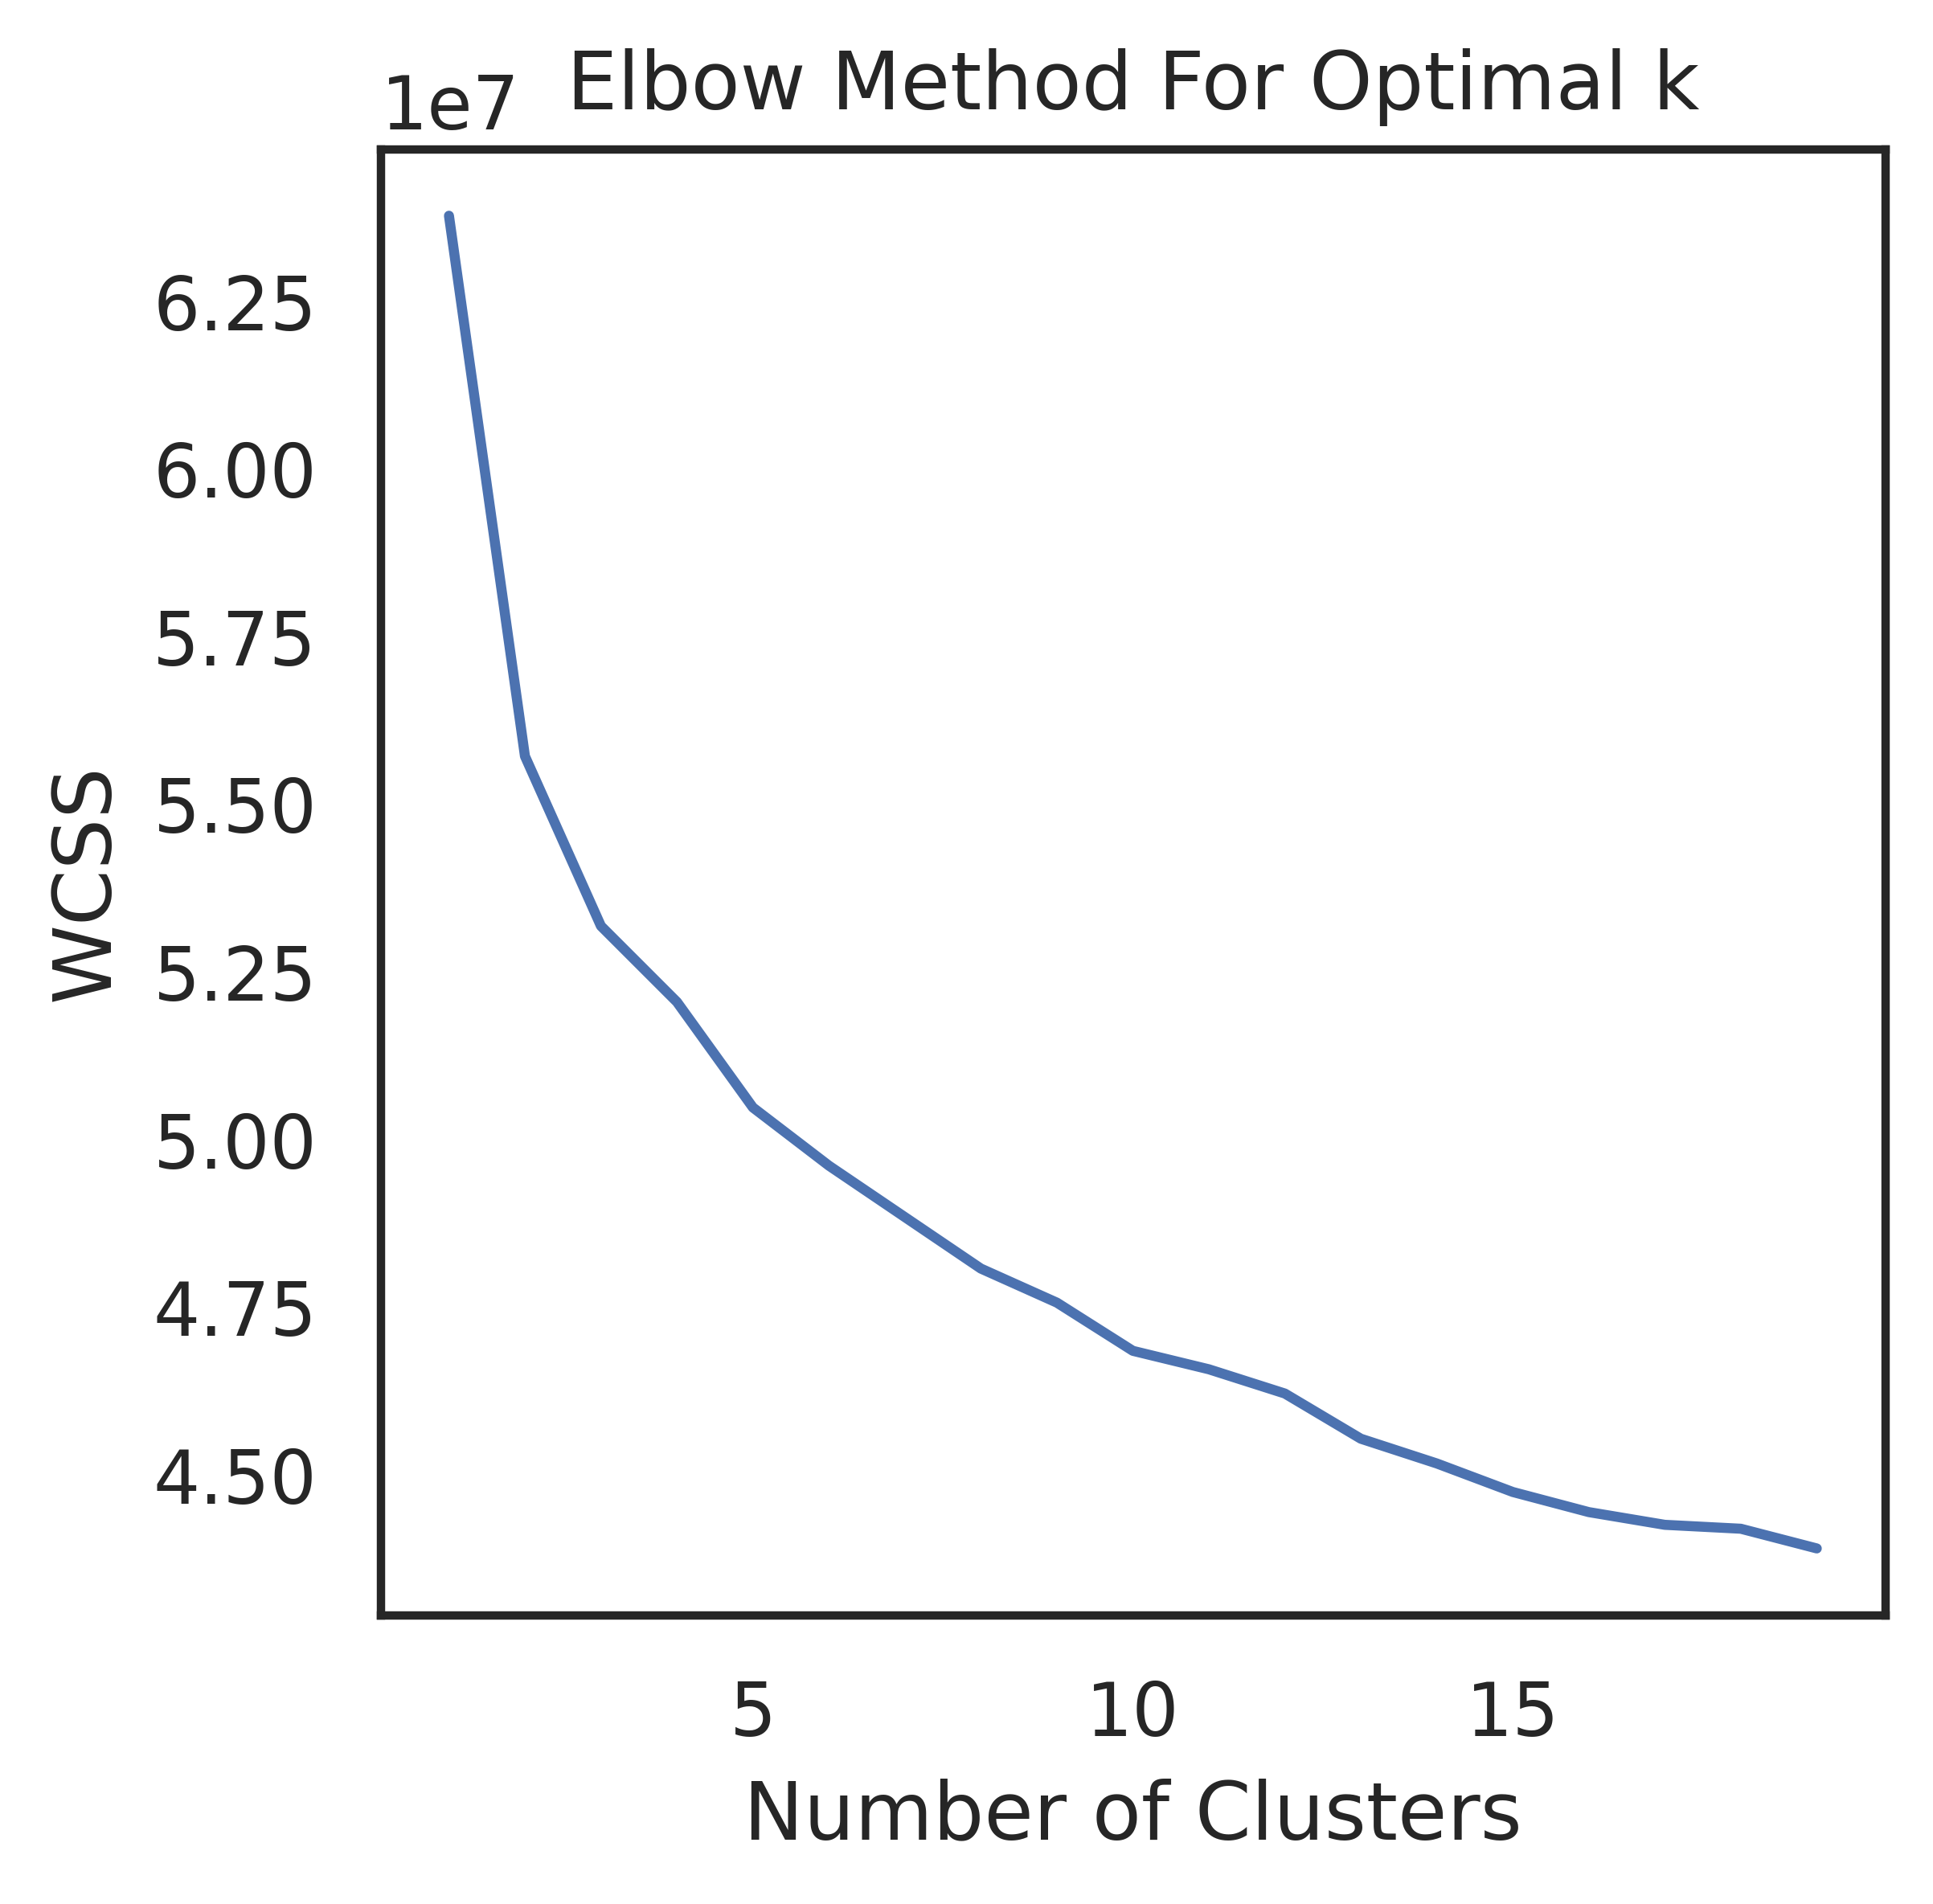

In [63]:
# Fit the model for a range of cluster numbers
wcss = []  # List to store the Within-Cluster Sum of Squares (WCSS)

for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init = 10)
    kmeans.fit(AML_malig_sub.X) 
    wcss.append(kmeans.inertia_)

# Plot the Elbow method
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [68]:
# Perform K-means clustering on the selected genes' data
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters,
                init = "k-means++",
                random_state= 42,
                n_init = 15)
AML_malig_sub.obs['cluster'] = pd.Categorical(kmeans.fit_predict(AML_malig_sub.X))

In [8]:
def rename_clusters(clusters):
    if clusters in ["0"]:
        return "Primitive_blastsI"
    if clusters in ["1"]:
        return "Cycling_cells"
    if clusters in ["2"]:
        return "Myeloid_mature_like"
    if clusters in ["3"]:
        return "AML12_specific"
    if clusters in ["4"]:
        return "GMP_like_state"
    if clusters in ["5"]:
        return "LSC_like"
    if clusters in ["6"]:
        return "Primitive_blastsII"
    else:
        return "Healthy"

AML_malig["rna"].obs["cluster_annotation"] = AML_malig["rna"].obs["cluster"].map(rename_clusters)

In [19]:
color_dict_groups = {
    'Healthy': 'lightgrey',  # Coral red
    'Stem_like_shared': 'brown',  # Turquoise
    'Primitive_blastsII': '#45B7D1',  # Sky blue
    'Primitive_blastsI': 'blue',  # Yellow
    'Cycling_cells': '#9B59B6',  # Purple
    'Myeloid_mature_like': '#E67E22',  # Orange
    'AML12_specific': 'pink',  # Emerald
    'GMP_like_state': 'green'  # Blue
}

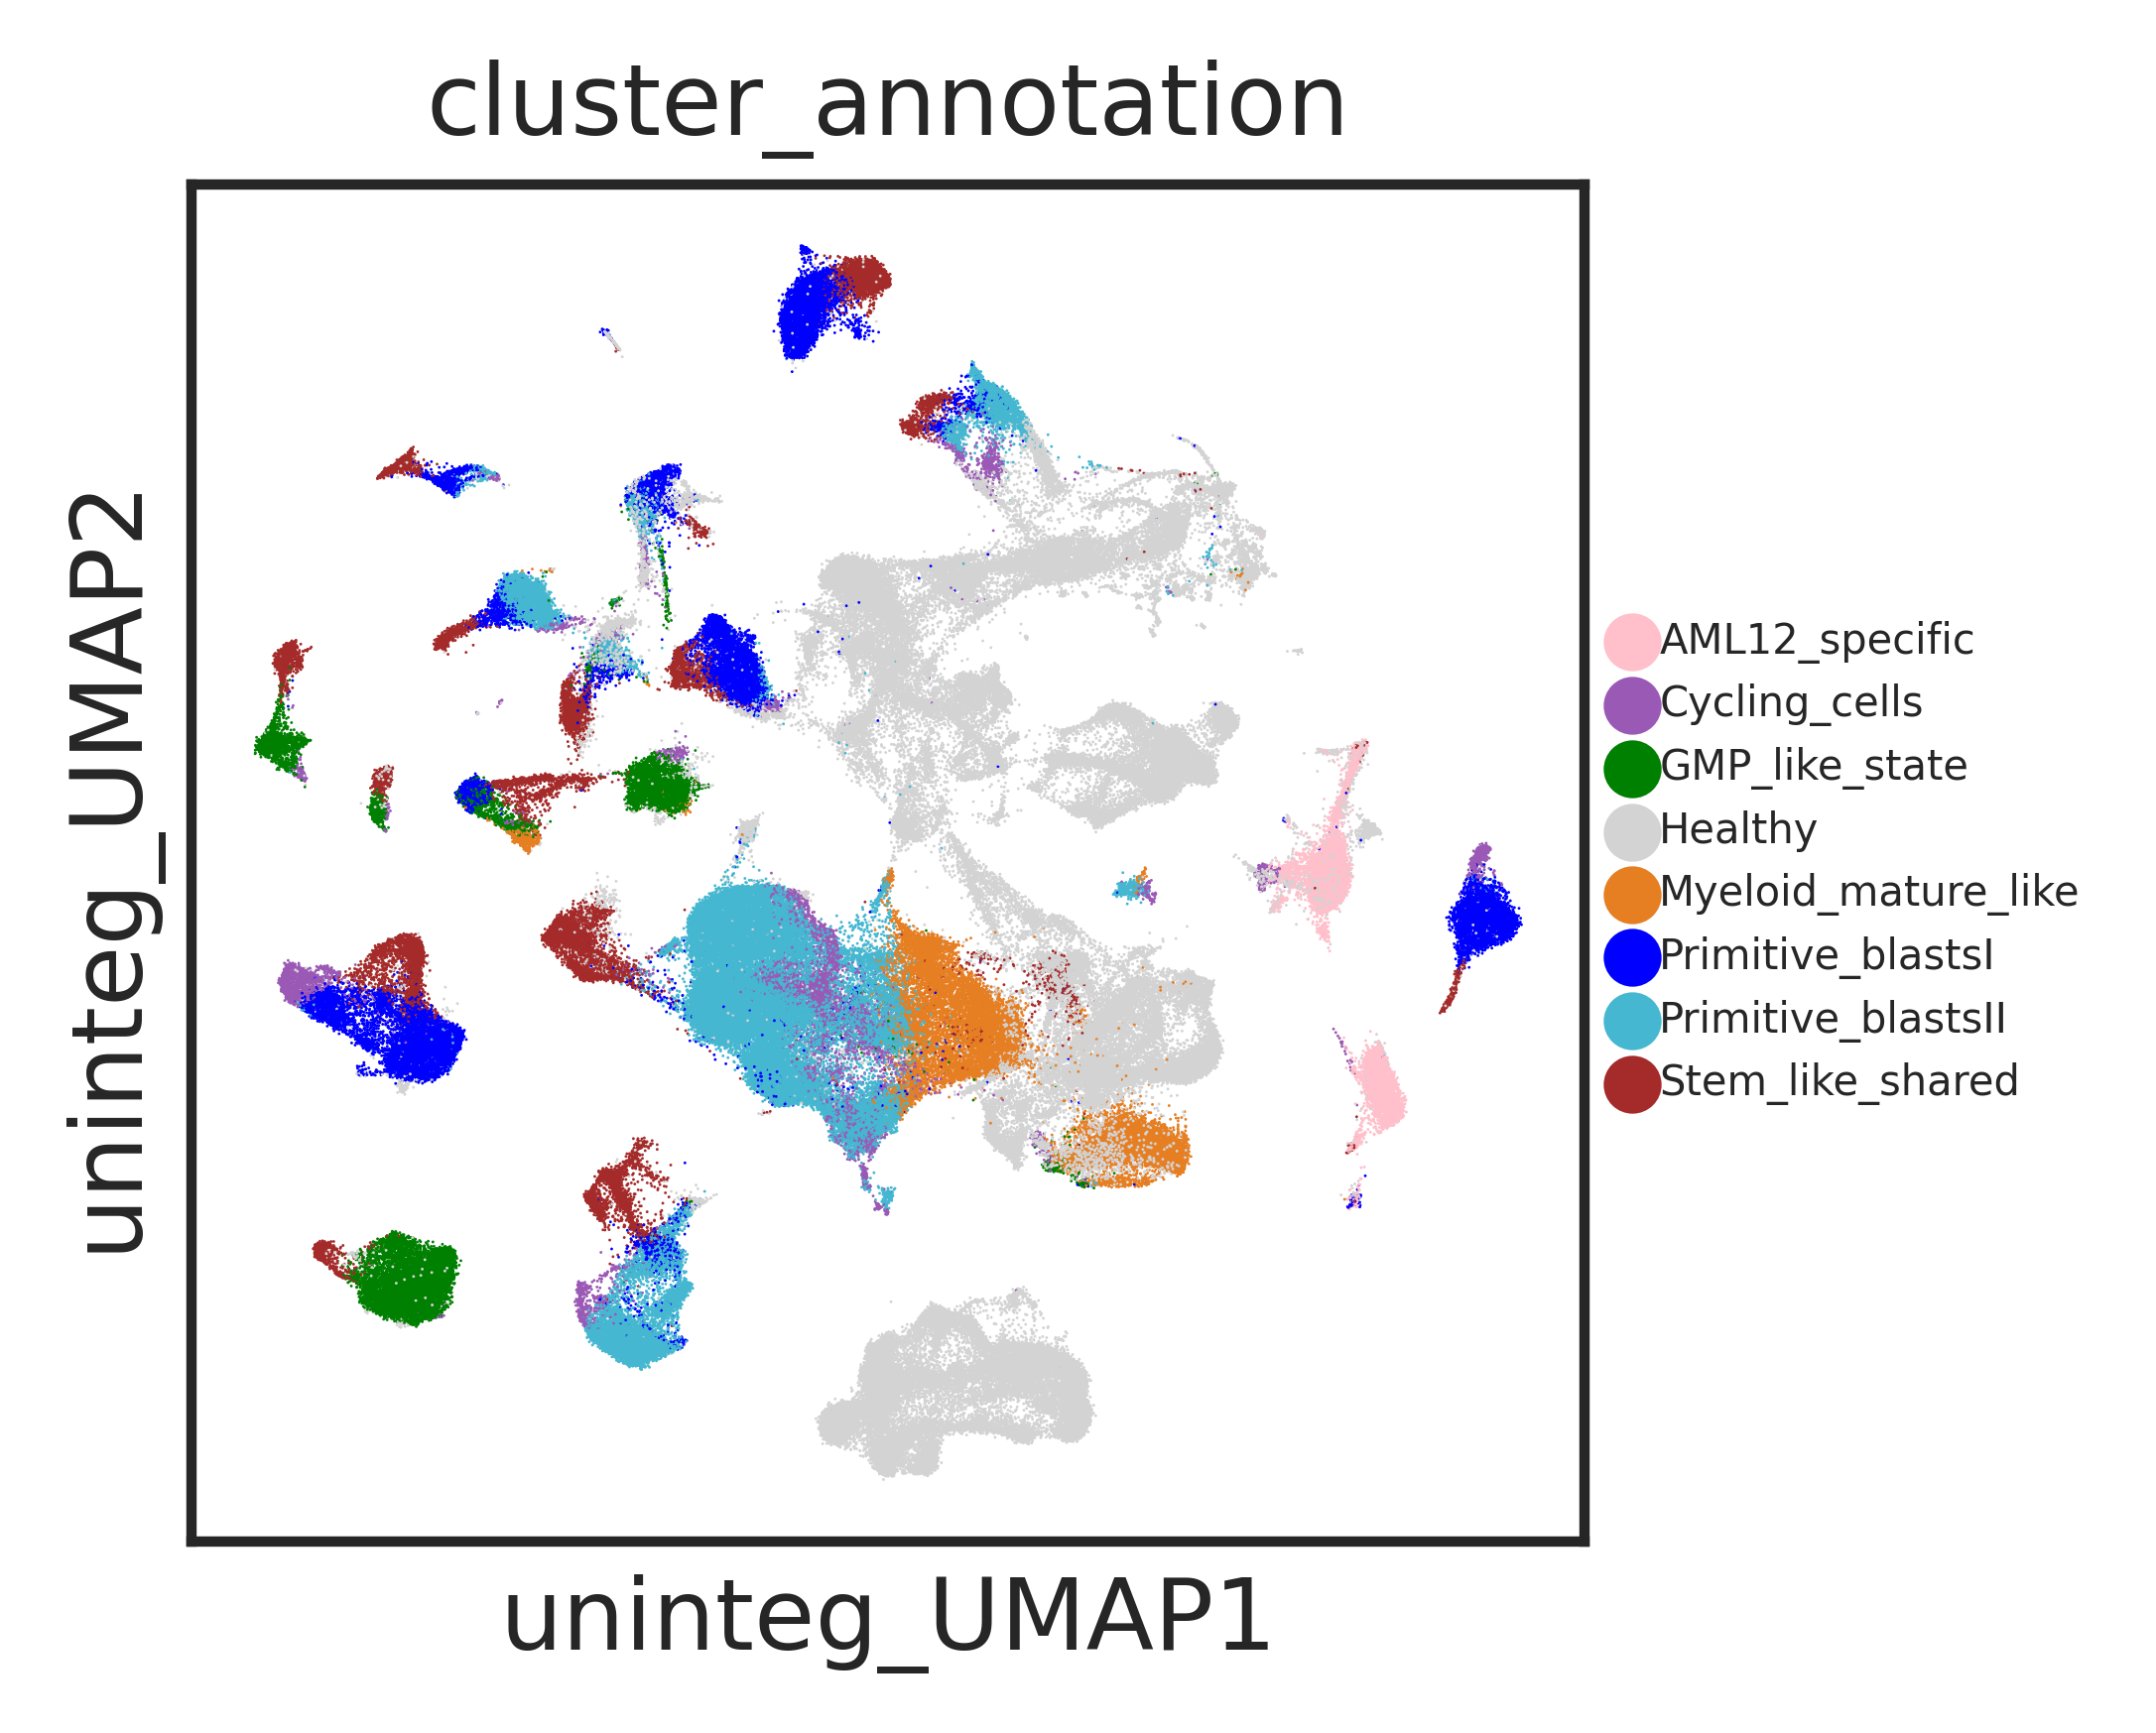

In [22]:
with rc_context({'figure.figsize': (3, 3)}):

 sc.pl.embedding(AML_all["rna"], color= ["cluster_annotation"], basis = "uninteg_UMAP", legend_fontsize = 5,legend_fontweight = "medium", legend_fontoutline = 3,
                 ncols = 1, vmin = "p5", vmax = "p99" , 
                 color_map = "coolwarm", layer= "lognorm_counts", palette = color_dict_groups, save = "UMAP_clusters.pdf"
)

In [12]:
categories_order = ["LSC_like","Primitive_blastsI","Primitive_blastsII",
                    "GMP_like_state","Myeloid_mature_like","Cycling_cells","AML12_specific"]

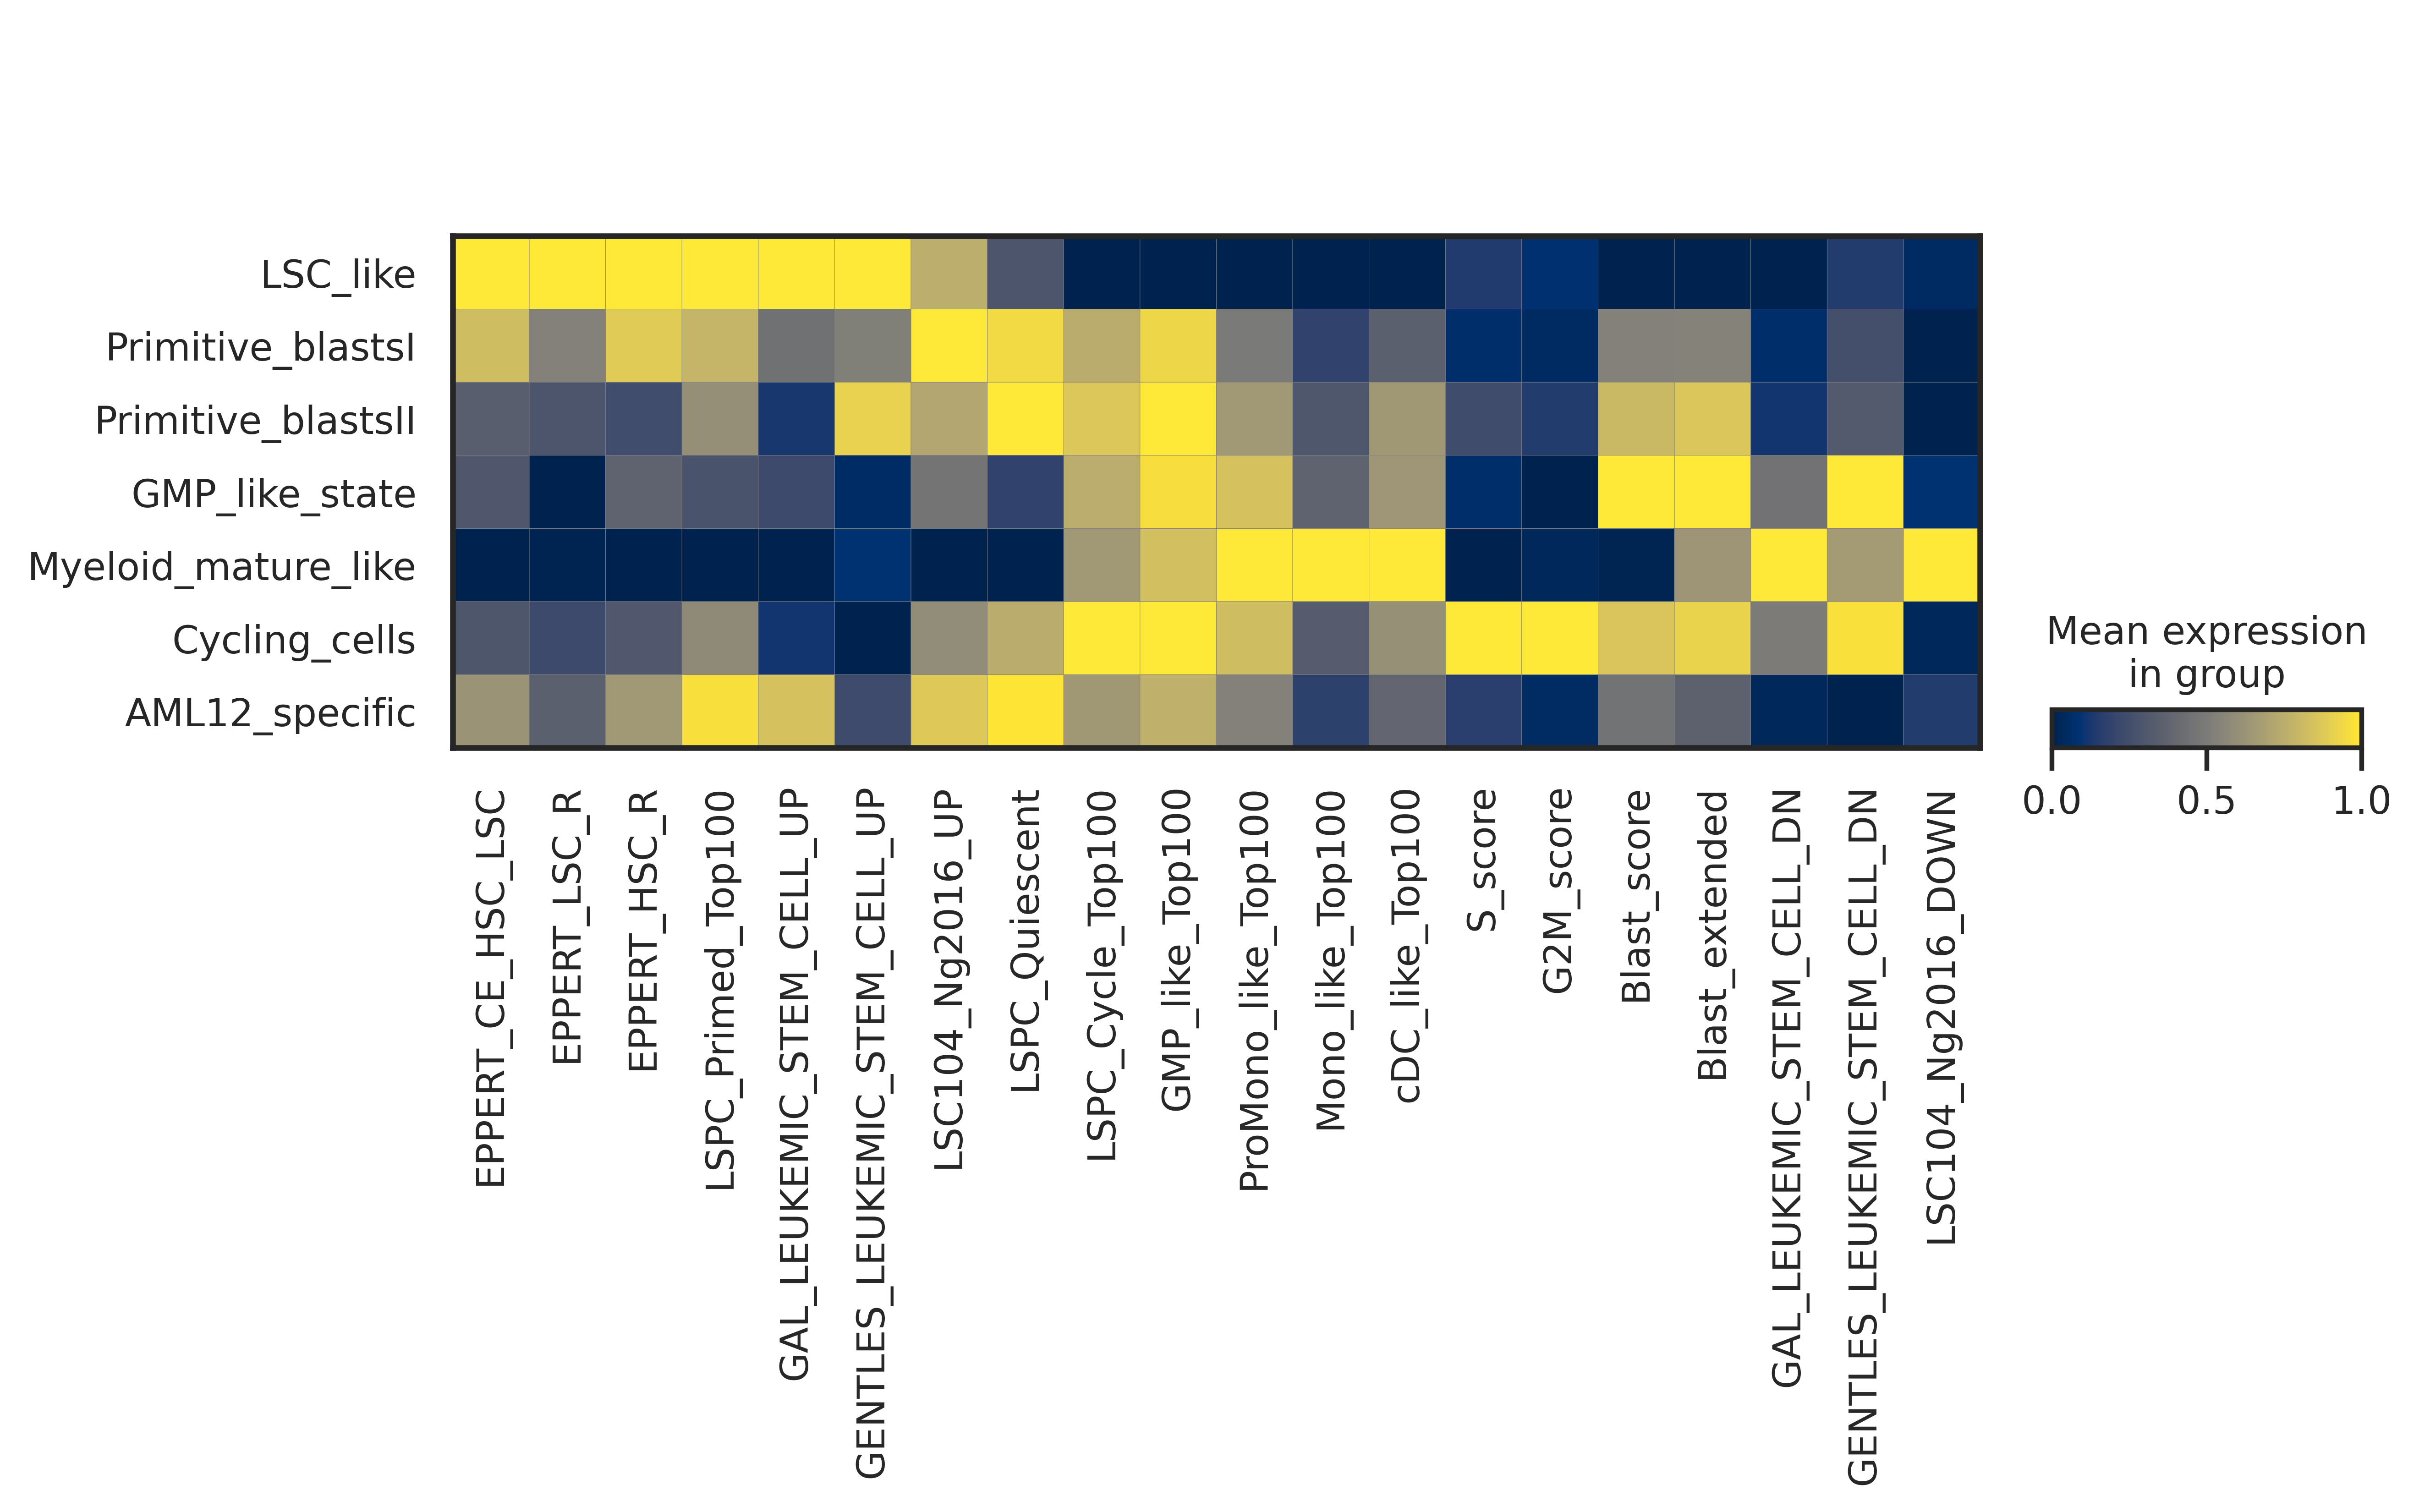

In [13]:
sc.pl.matrixplot(AML_malig["rna"], 
                     var_names = ["EPPERT_CE_HSC_LSC","EPPERT_LSC_R","EPPERT_HSC_R","LSPC_Primed_Top100",
                                  "GAL_LEUKEMIC_STEM_CELL_UP","GENTLES_LEUKEMIC_STEM_CELL_UP","LSC104_Ng2016_UP",
                                  "LSPC_Quiescent",'LSPC_Cycle_Top100','GMP_like_Top100',
       'ProMono_like_Top100', 'Mono_like_Top100', 'cDC_like_Top100','S_score', 'G2M_score', 'Blast_score',
       'Blast_extended','GAL_LEUKEMIC_STEM_CELL_DN', 'GENTLES_LEUKEMIC_STEM_CELL_DN',
       'LSC104_Ng2016_DOWN'],
                    groupby = "cluster_annotation",
                 categories_order = categories_order, standard_scale = "var",
                 cmap = "cividis", save = "Scores_heeatmap.pdf")

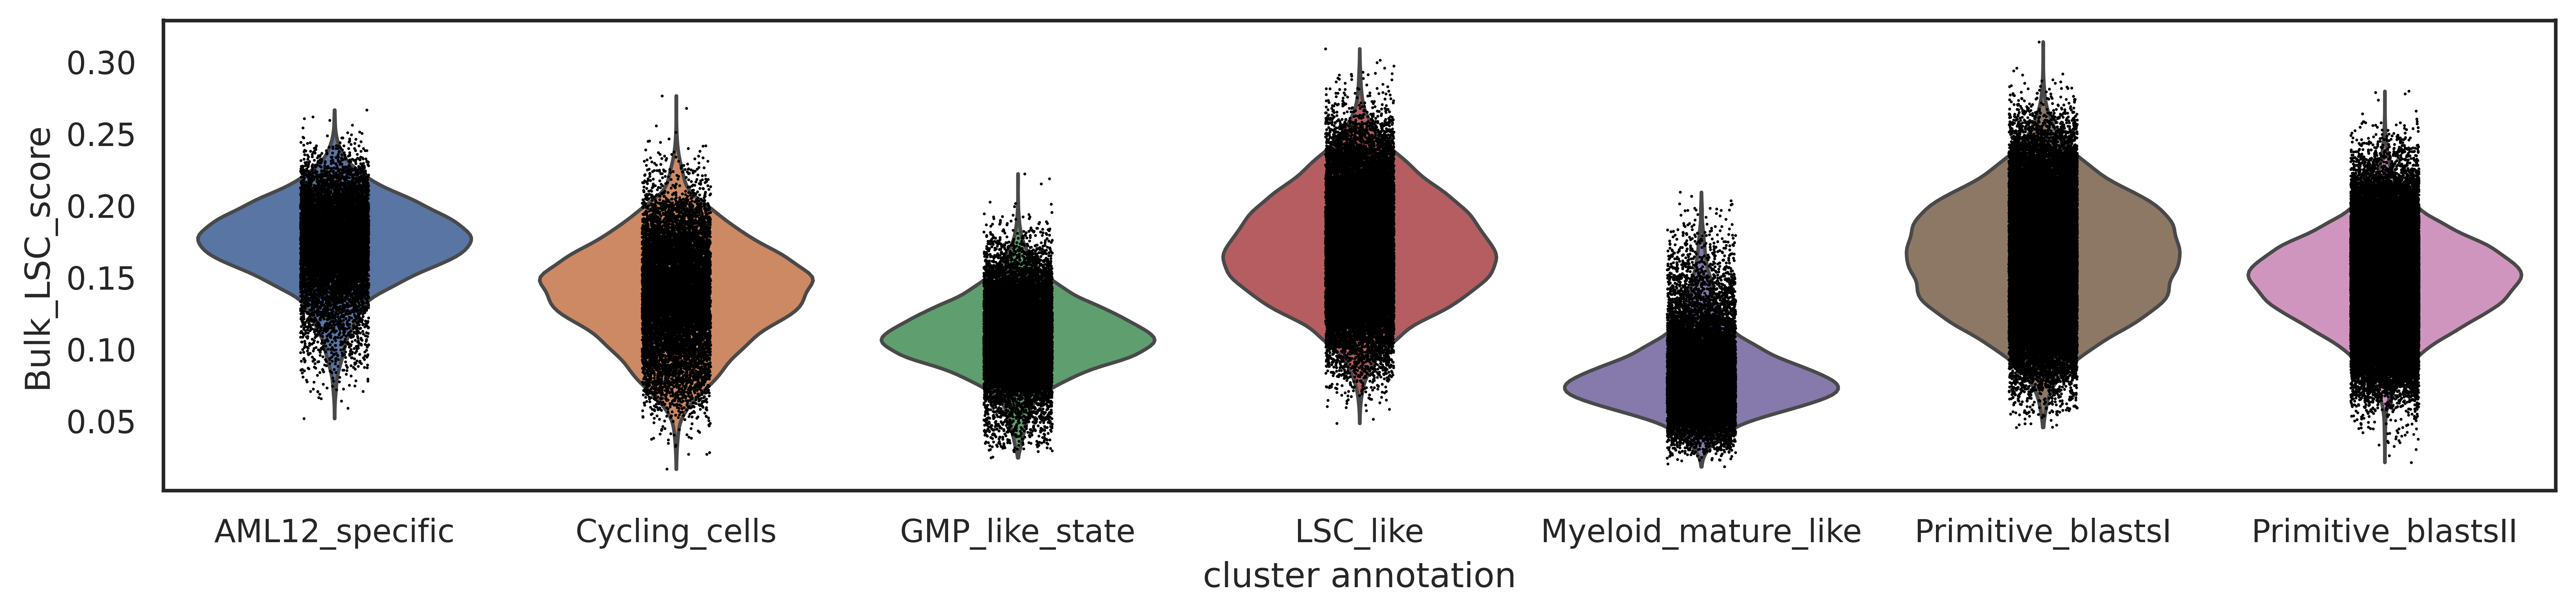

In [35]:
with rc_context({'figure.figsize': (12, 3)}):
    sc.pl.violin(AML_malig["rna"], groupby = "cluster_annotation", keys = ["Bulk_LSC_score"])

In [47]:
# Extract LSC-like cells
lsc_scores = AML_malig["rna"].obs.loc[
    AML_malig["rna"].obs["cluster_annotation"] == "LSC_like", "Bulk_LSC_score"
]

# Extract all other malignant cells
rest_scores = AML_malig["rna"].obs.loc[
    AML_malig["rna"].obs["cluster_annotation"] != "LSC_like", "Bulk_LSC_score"
]

# Wilcoxon rank-sum test (Mann–Whitney U)
stat, pval = stats.mannwhitneyu(lsc_scores, rest_scores, alternative="two-sided")

# FDR correction (works even if you only have one p-value now, but scalable to many)
rejected, pvals_corrected, _, _ = multipletests([pval], method="fdr_bh")

print("Mean LSC-like score:", lsc_scores.mean())
print("Mean Rest score:", rest_scores.mean())
print("Mann–Whitney U statistic:", stat)
print("Raw p-value:", pval)
print("FDR-corrected p-value:", pvals_corrected[0])


Mean LSC-like score: 0.17046884
Mean Rest score: 0.14056395
Mann–Whitney U statistic: 2104571405.0
Raw p-value: 0.0
FDR-corrected p-value: 0.0


In [49]:

# Extract LSC-like cells
lsc_scores = AML_malig["rna"].obs.loc[
    AML_malig["rna"].obs["cluster_annotation"] == "LSC_like", "Blast_score"
]

# Extract all other malignant cells
rest_scores = AML_malig["rna"].obs.loc[
    AML_malig["rna"].obs["cluster_annotation"] != "LSC_like", "Blast_score"
]

# Wilcoxon rank-sum test (Mann–Whitney U)
stat, pval = stats.mannwhitneyu(lsc_scores, rest_scores, alternative="two-sided")

# FDR correction (works even if you only have one p-value now, but scalable to many)
rejected, pvals_corrected, _, _ = multipletests([pval], method="fdr_bh")

print("Mean LSC-like  Blast score:", lsc_scores.mean())
print("Mean Rest score:", rest_scores.mean())
print("Mann–Whitney U statistic:", stat)
print("Raw p-value:", pval)
print("FDR-corrected p-value:", pvals_corrected[0])


Mean LSC-like  Blast score: 0.10876434
Mean Rest score: 0.26291096
Mann–Whitney U statistic: 567418855.0
Raw p-value: 0.0
FDR-corrected p-value: 0.0


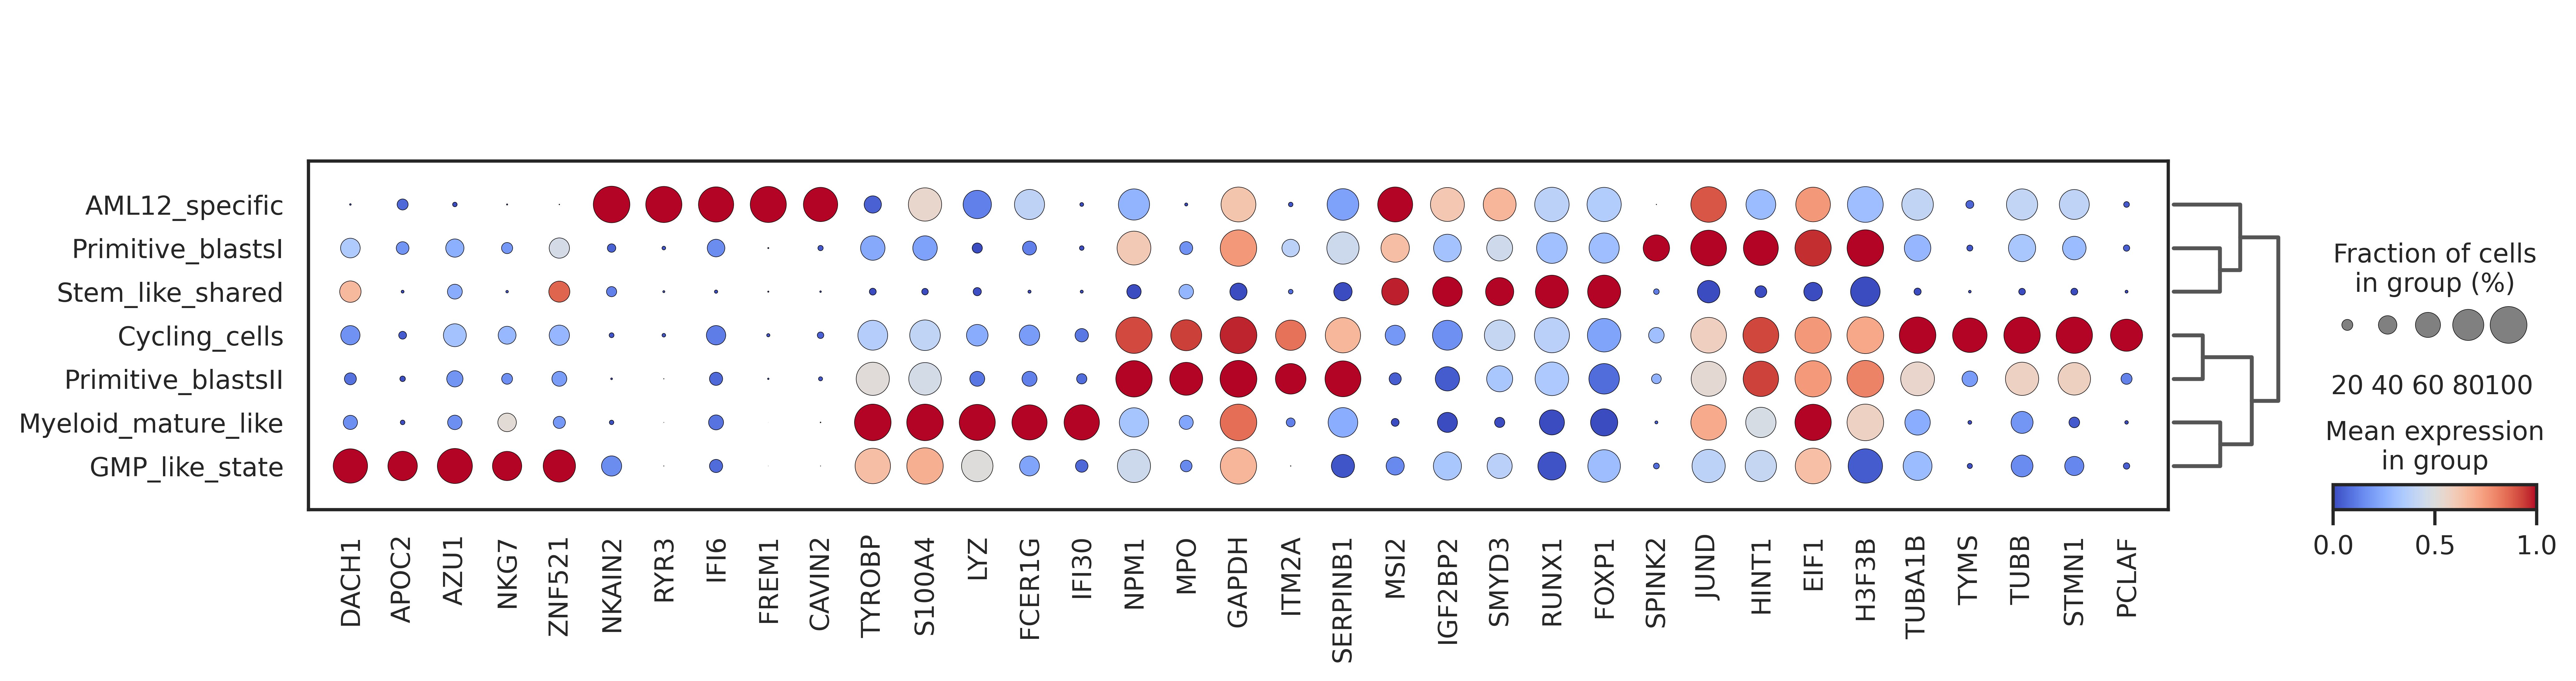

In [19]:
sc.pl.dotplot(AML_malig["rna"], groupby = "cluster_annotation",cmap = "coolwarm", var_names = ["DACH1","APOC2","AZU1","NKG7","ZNF521",
                                                              "NKAIN2", "RYR3","IFI6","FREM1","CAVIN2",
                                                               "TYROBP","S100A4","LYZ","FCER1G","IFI30",
                                                              "NPM1", "MPO","GAPDH","ITM2A","SERPINB1",
                                                              "MSI2","IGF2BP2","SMYD3","RUNX1","FOXP1",
                                                              "SPINK2","JUND","HINT1","EIF1","H3F3B",
                                                              "TUBA1B","TYMS","TUBB","STMN1","PCLAF"],
              dendrogram = True,standard_scale = "var", save = "Gnenes_sig_clusters.pdf")

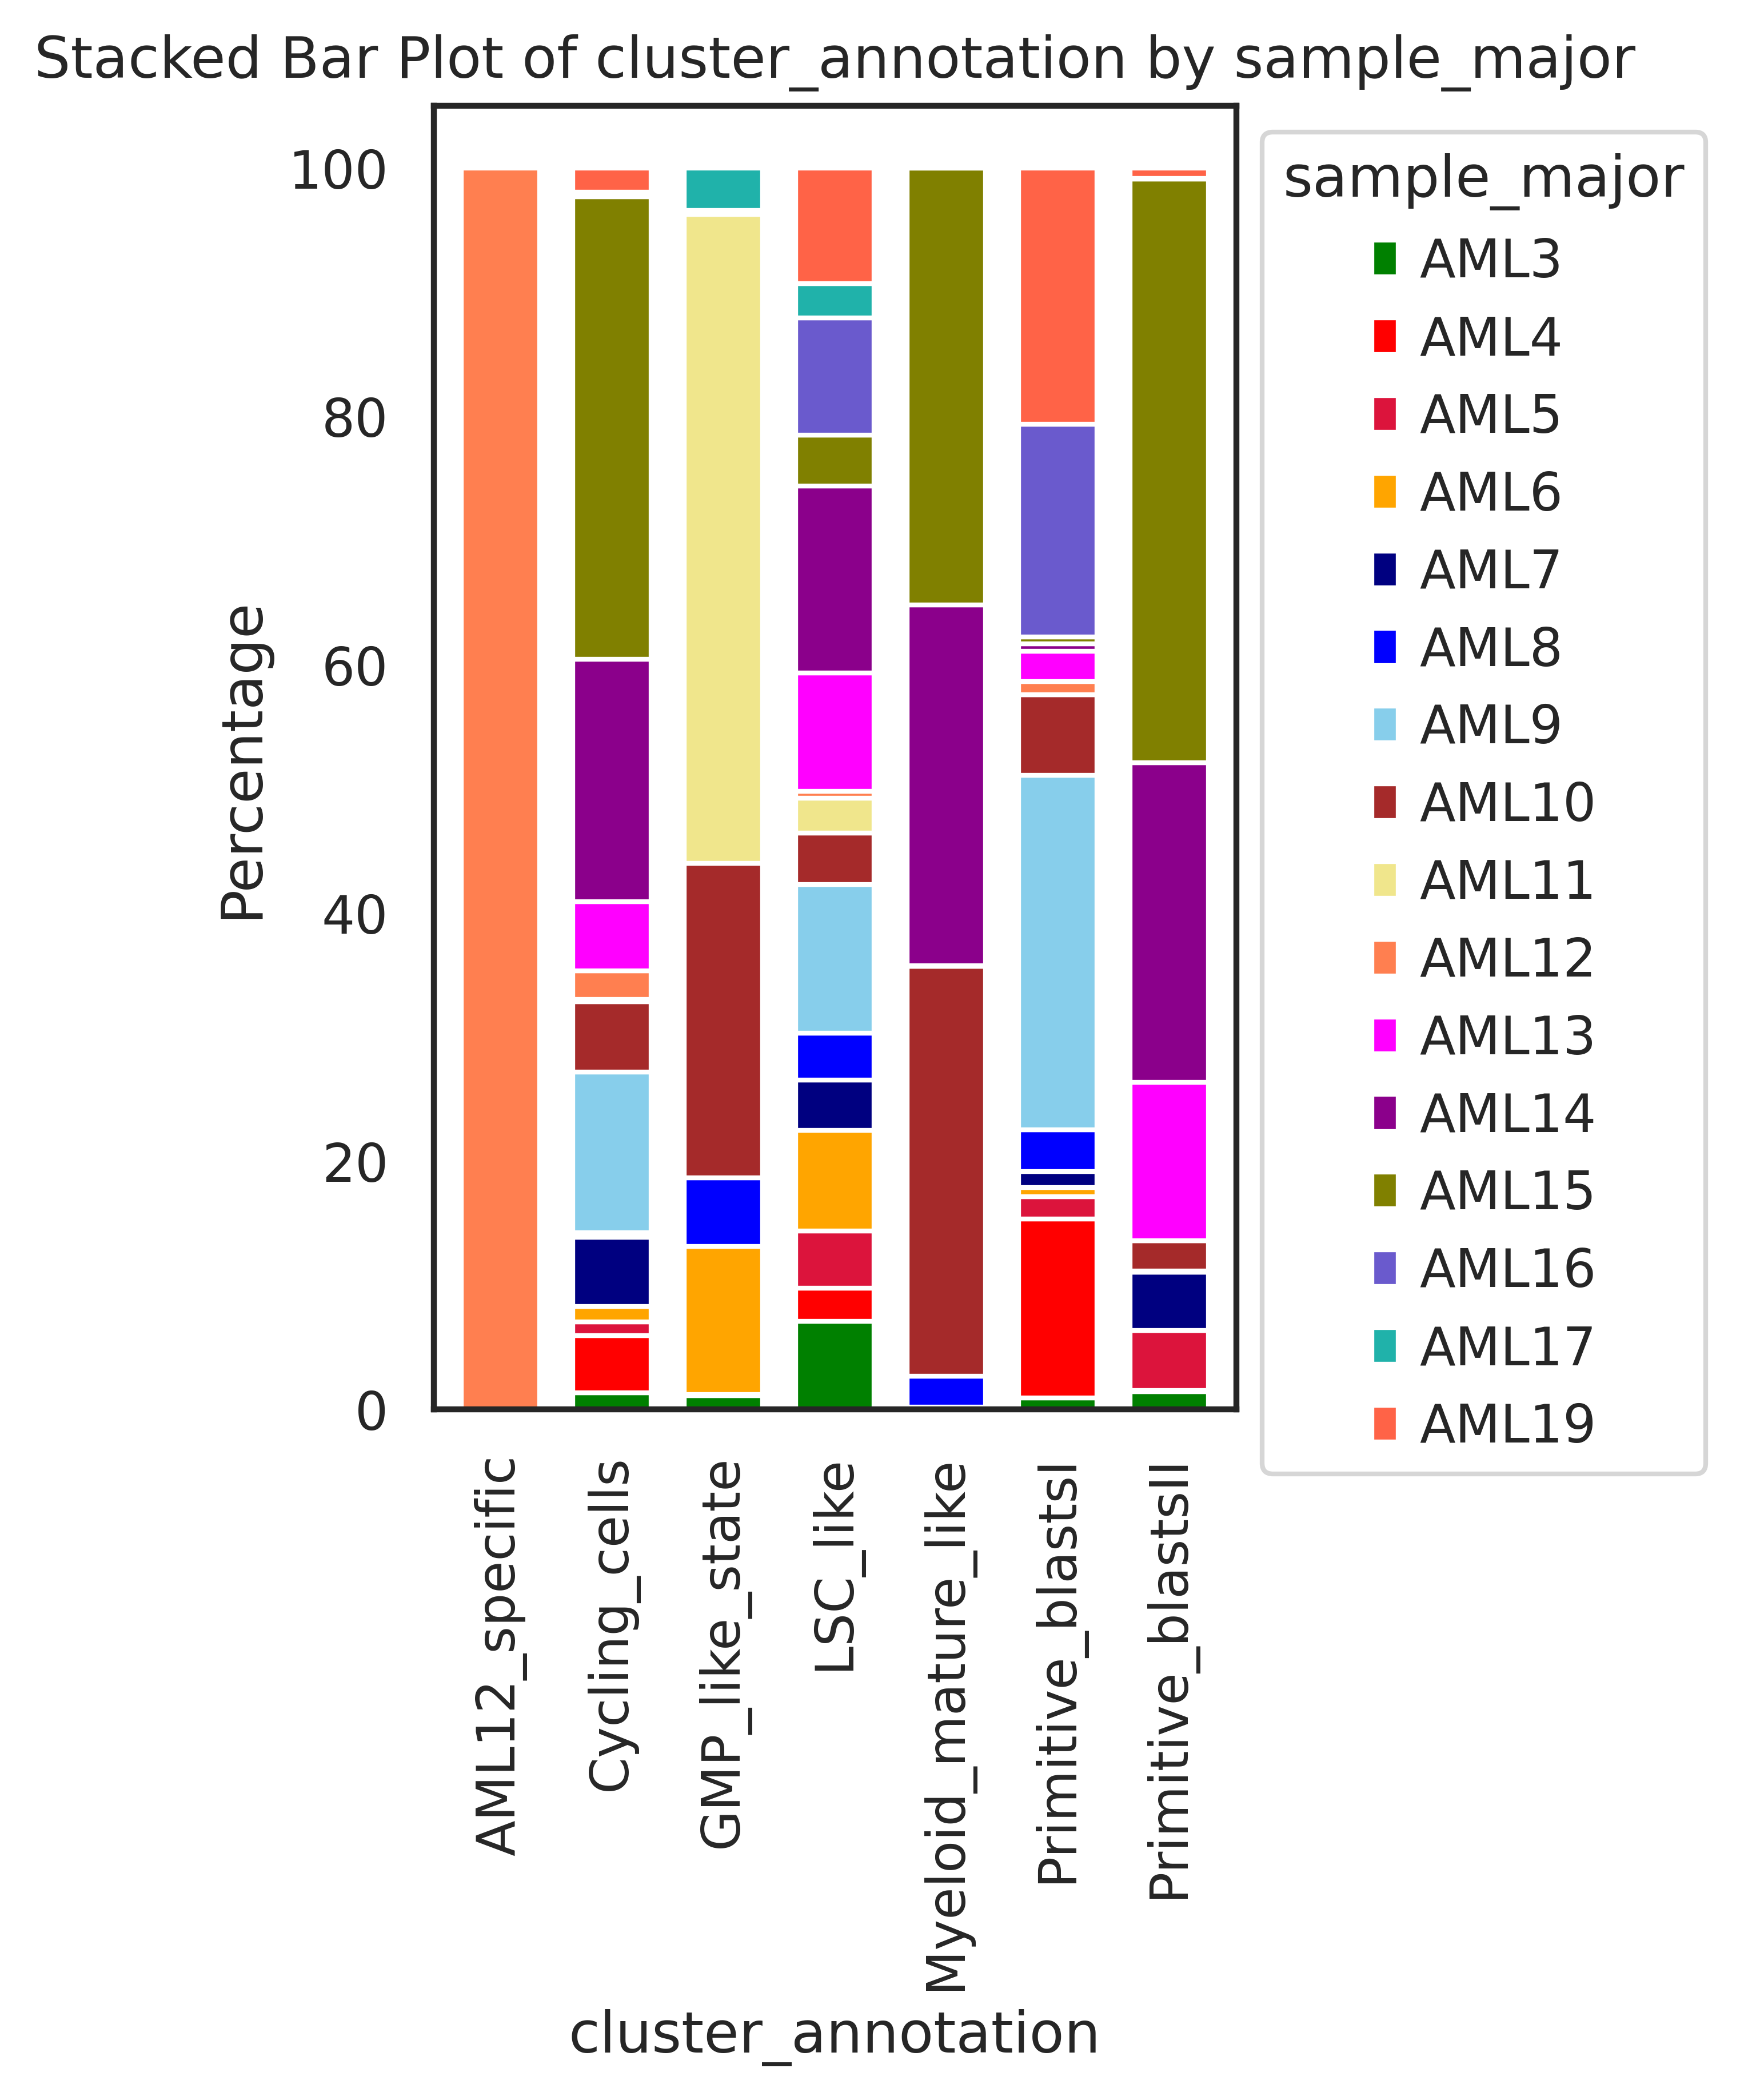

In [11]:
plot_stacked_barplot(AML_malig["rna"], 
                     groupby_columns=["cluster_annotation", "sample_major"],
                     color_dict=color_dict_sample_broad, figsize=(3, 5),
                     save_path = "/Cluster_sample_barplot.pdf")

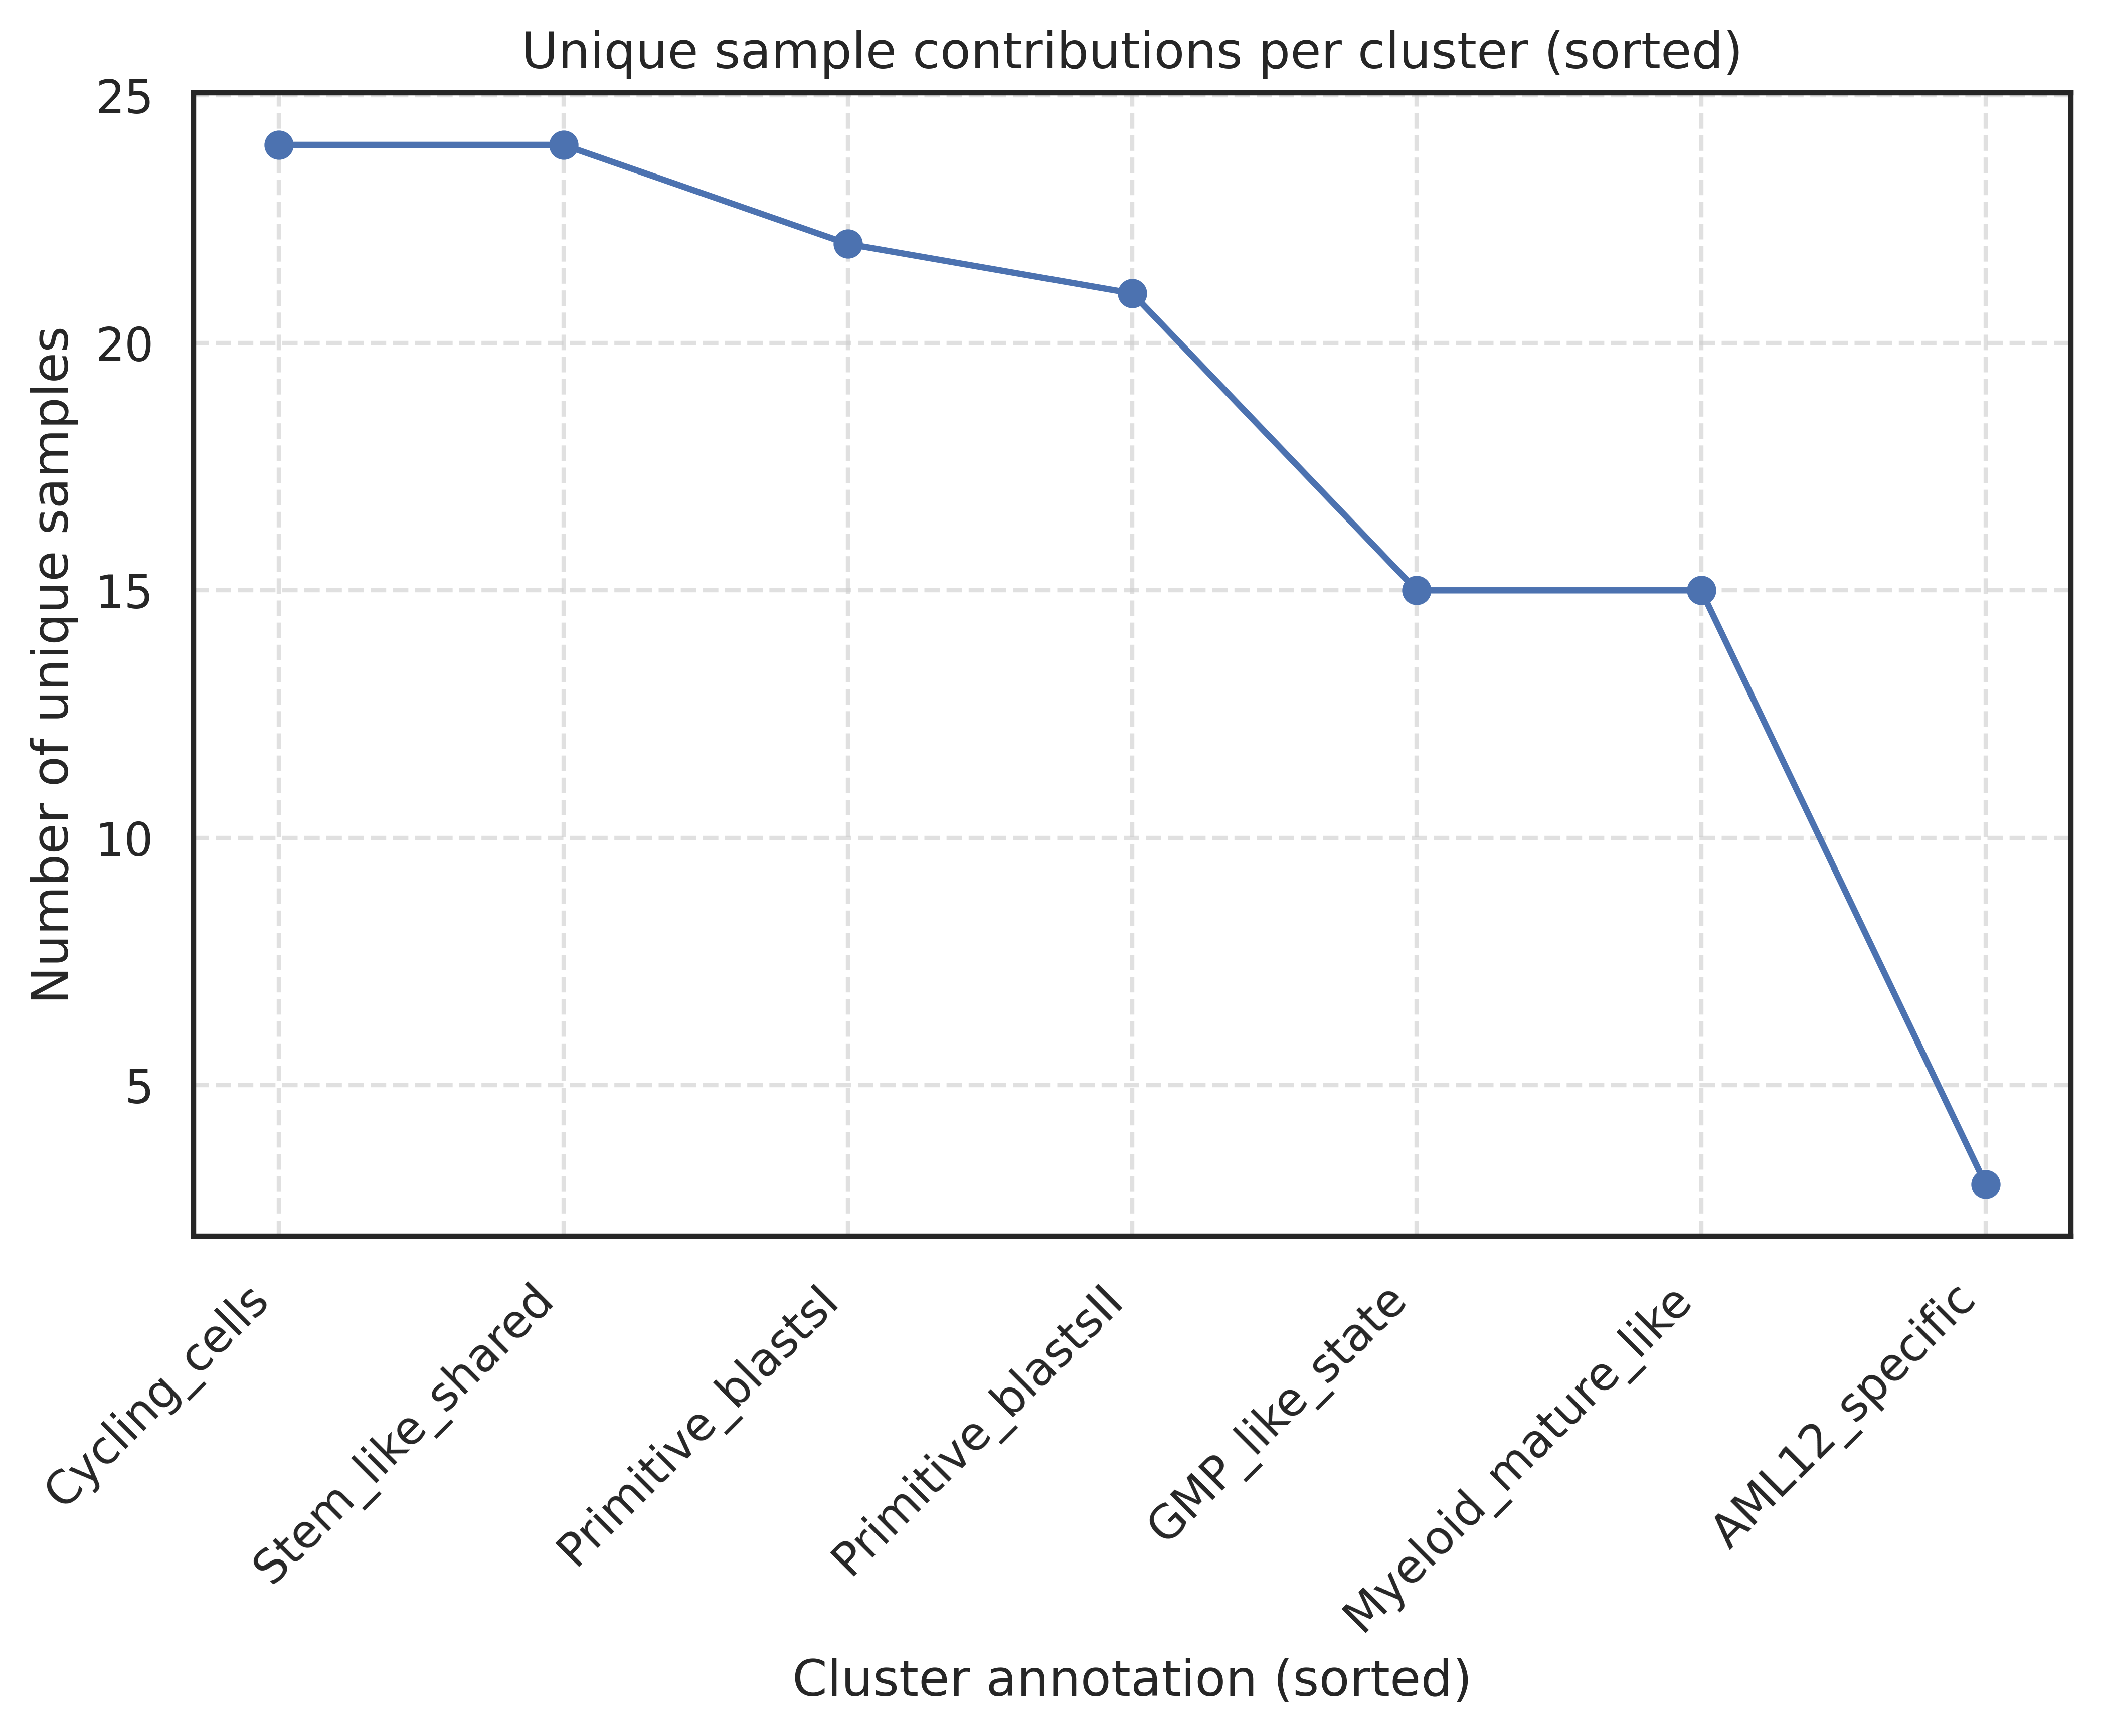

In [36]:
# Count unique samples per cluster and sort
unique_samples_per_cluster = (
    AML_malig["rna"].obs.groupby("cluster_annotation")["sample"].nunique().sort_values(ascending=False)
)

# Line plot
plt.figure(figsize=(8,5))
unique_samples_per_cluster.plot(marker="o", linestyle="-")
plt.ylabel("Number of unique samples")
plt.xlabel("Cluster annotation (sorted)")
plt.title("Unique sample contributions per cluster (sorted)")
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig('/contribution_line_plot_groups.pdf', 
            dpi=300,  # High resolution
            bbox_inches='tight',  # Tight bounding box
            pad_inches=0.2,  # Add some padding
            format='pdf')
plt.show()
